# OCEAN Token Sentiment Analysis Challenge
## Data Exploration

## import

In [2]:
import os
import sys
from pathlib import Path
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# not compatible with TextBlob on Mac M1 :
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping

from textblob import TextBlob

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

## definitions

In [3]:
path_data = "data"
path_source_prices = os.path.join(path_data, "OCEAN token price dataset.csv")
path_source_tweets = os.path.join(path_data, "OCEAN tweets dataset.csv")

## Load raw data

In [4]:
df_raw_prices = pd.read_csv(path_source_prices)
df_raw_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215
...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566


In [5]:
df_raw_tweets = pd.read_csv(path_source_tweets)
df_raw_tweets

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1583608299085500416,1583289720846618627,2022-10-22 02:56:55 GTB (heure d’été),2022-10-22,02:56:55,300,1265742995636326401,mxyzptlk07,Mxyzptlk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'JakeGagain', 'name': 'Jake G...",NaN,NaN,NaN,NaN
1,1583607565543669761,1583607565543669761,2022-10-22 02:54:00 GTB (heure d’été),2022-10-22,02:54:00,300,1265742995636326401,mxyzptlk07,Mxyzptlk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1583603064044367872,1583603064044367872,2022-10-22 02:36:07 GTB (heure d’été),2022-10-22,02:36:07,300,1319369787848405003,moonhodler2,MOONHODLER,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1583598008511664128,1583595613903417344,2022-10-22 02:16:01 GTB (heure d’été),2022-10-22,02:16:01,300,3275094379,rjgaurav338,rikdbxs,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'CryptoGemsCom', 'name': 'The...",NaN,NaN,NaN,NaN
4,1583595987851173888,1583557616558833665,2022-10-22 02:07:59 GTB (heure d’été),2022-10-22,02:07:59,300,1258748447873806336,stringerbcoiner,StringerBitcoiner,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'cryptoworld202', 'name': 'Cr...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229852,1211845595977019392,1211774284965859328,2019-12-31 05:04:39 GTB,2019-12-31,05:04:39,300,3307664430,mojo_crypto_btc,🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
229853,1211830366513901568,1211782150443479042,2019-12-31 04:04:08 GTB,2019-12-31,04:04:08,300,897905830334533632,harmoniccapital,Harmonic Capital,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'DaveCryptos', 'name': 'Dave ...",NaN,NaN,NaN,NaN
229854,1211818209738817536,1211818209738817536,2019-12-31 03:15:50 GTB,2019-12-31,03:15:50,300,999799024273141760,bakeobits,ShillSilverstein.kek 📈👑📉,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
229855,1211808120659300352,1211808120659300352,2019-12-31 02:35:44 GTB,2019-12-31,02:35:44,300,999799024273141760,bakeobits,ShillSilverstein.kek 📈👑📉,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


## Clean Data

### Check data

In [6]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing


print("Check prices : ")
nb_missing = get_missing(df_raw_prices)

assert len(nb_missing)==0, "NaN value(s) in the prices!"
print("Prices ok")
df_prices = df_raw_prices.copy()

Check prices : 
missing data : 
Series([], dtype: int64)

on 1485 samples
Prices ok


In [7]:
print("Check tweets : ")
nb_missing = get_missing(df_raw_tweets)

Check tweets : 
missing data : 
name                18
thumbnail       172538
quote_url       198764
trans_src       229857
near            229857
geo             229857
source          229857
user_rt_id      229857
user_rt         229857
retweet_id      229857
place           229857
retweet_date    229857
translate       229857
trans_dest      229857
dtype: int64

on 229857 samples


In [8]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

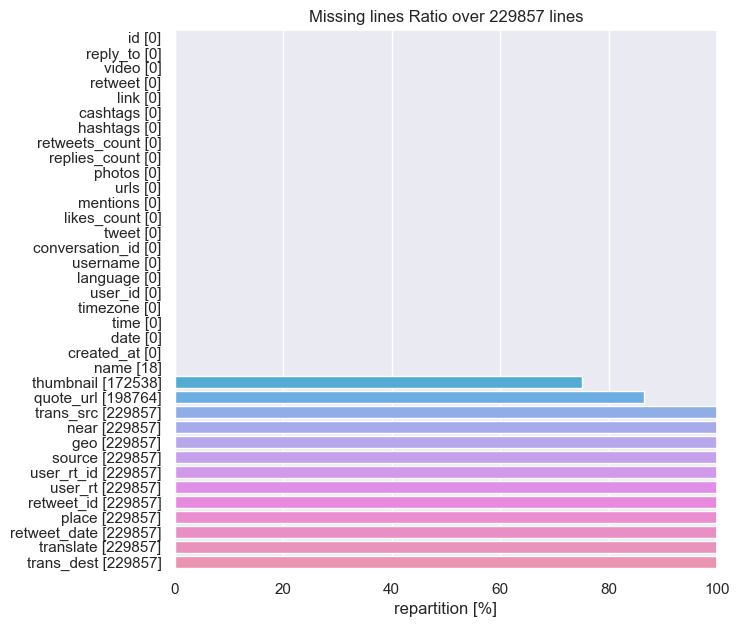

In [9]:
df_miss = display_missing(df_raw_tweets)

First strat, keep only columns where NaN values are < 90% of all values

In [167]:
df_miss[df_miss["ratio"] >= 90].index.to_list()

['trans_src',
 'near',
 'geo',
 'source',
 'user_rt_id',
 'user_rt',
 'retweet_id',
 'place',
 'retweet_date',
 'translate',
 'trans_dest']

In [10]:
list_col = df_miss[df_miss["ratio"] < 90].index.to_list()
list_col

['id',
 'reply_to',
 'video',
 'retweet',
 'link',
 'cashtags',
 'hashtags',
 'retweets_count',
 'replies_count',
 'photos',
 'urls',
 'mentions',
 'likes_count',
 'tweet',
 'conversation_id',
 'username',
 'language',
 'user_id',
 'timezone',
 'time',
 'date',
 'created_at',
 'name',
 'thumbnail',
 'quote_url']

In [11]:
df_tweets = df_raw_tweets[list_col].copy()
print("Check tweets : ")
nb_missing = get_missing(df_tweets)



Check tweets : 
missing data : 
name             18
thumbnail    172538
quote_url    198764
dtype: int64

on 229857 samples


In [12]:
df_tweets["quote_url"]

0                                                       NaN
1         https://twitter.com/oceanprotocol/status/15834...
2         https://twitter.com/oceanprotocol/status/15834...
3                                                       NaN
4                                                       NaN
                                ...                        
229852                                                  NaN
229853                                                  NaN
229854                                                  NaN
229855                                                  NaN
229856                                                  NaN
Name: quote_url, Length: 229857, dtype: object

In [13]:
df_tweets["thumbnail"] 

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4         https://pbs.twimg.com/media/FfoQJTUWQAMjfYy.jpg
                               ...                       
229852                                                NaN
229853                                                NaN
229854                                                NaN
229855    https://pbs.twimg.com/media/ENE1D4GUYAAWcVh.jpg
229856                                                NaN
Name: thumbnail, Length: 229857, dtype: object

In [14]:
df_tweets["name"]

0                              Mxyzptlk
1                              Mxyzptlk
2                            MOONHODLER
3                               rikdbxs
4                     StringerBitcoiner
                      ...              
229852    🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL
229853                 Harmonic Capital
229854         ShillSilverstein.kek 📈👑📉
229855         ShillSilverstein.kek 📈👑📉
229856                 Tycho Waterhouse
Name: name, Length: 229857, dtype: object

In [15]:
df_tweets["link"]

0         https://twitter.com/Mxyzptlk07/status/15836082...
1         https://twitter.com/Mxyzptlk07/status/15836075...
2         https://twitter.com/Moonhodler2/status/1583603...
3         https://twitter.com/rjgaurav338/status/1583598...
4         https://twitter.com/StringerBcoiner/status/158...
                                ...                        
229852    https://twitter.com/Mojo_Crypto_BTC/status/121...
229853    https://twitter.com/harmoniccapital/status/121...
229854    https://twitter.com/bakeobits/status/121181820...
229855    https://twitter.com/bakeobits/status/121180812...
229856    https://twitter.com/TychoWaterhouse/status/121...
Name: link, Length: 229857, dtype: object

### Time reference

Time reference between Prices & Tweets are not the same : 
- Prices seems to be in timezone UTC : on binance price open at 0.3506 and close 0.3581 on May 28th like data
- Tweet are UTC+3 time zone

We need to translate tweets date to UTC to be synchronized

In [16]:
df_tweets["timezone"].unique()

array([300])

In [17]:
df_tweets["date"]

0         2022-10-22
1         2022-10-22
2         2022-10-22
3         2022-10-22
4         2022-10-22
             ...    
229852    2019-12-31
229853    2019-12-31
229854    2019-12-31
229855    2019-12-31
229856    2019-12-31
Name: date, Length: 229857, dtype: object

In [18]:
df_tweets["link"][0]

'https://twitter.com/Mxyzptlk07/status/1583608299085500416'

In [19]:
df_tweets[df_tweets["date"] == "2022-06-01"].values[60]

array([1531975361663315970, '[]', 0, False,
       'https://twitter.com/hj_majeed7/status/1531975361663315970',
       "['ocean']", '[]', 2, 4, '[]', '[]', '[]', 9,
       '$OCEAN   THIS WEEK CAN BE A BIG WEEK FOR THIS COIN !   5-100% TARGET  SELL AT ANY PROPER PRICE',
       1531975361663315970, 'hj_majeed7', 'en', 1444718496924028942, 300,
       '15:26:03', '2022-06-01', '2022-06-01 15:26:03 GTB (heure d’été)',
       'HJMAJEED', nan, nan], dtype=object)

In [20]:
df_tweets["date"].max()

'2022-10-22'

In [21]:
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215
...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566


In [22]:
df_tweets.at[0, "date"]

'2022-10-22'

In [23]:
df_tweets.at[0, "time"]

'02:56:55'

In [24]:
date_str = '2023-02-15 16:00:00-05:00'
print(date_str)
date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
print(date_str)

2023-02-15 16:00:00-05:00
2023-02-15T21:00:00Z


In [25]:
def fun_tweets_time(str_date):
    return " " + str_date + "+03:00"


df_tweets["time_utc"] = df_tweets["time"].copy().apply(fun_tweets_time)
df_tweets["time_utc"] = df_tweets["date"].copy() + df_tweets["time_utc"]
df_tweets["time_utc"] = pd.to_datetime(df_tweets["time_utc"], utc=True)
df_tweets["date_utc"] = df_tweets["time_utc"].dt.strftime("%Y-%m-%d")
df_tweets["time_utc"]

0        2022-10-21 23:56:55+00:00
1        2022-10-21 23:54:00+00:00
2        2022-10-21 23:36:07+00:00
3        2022-10-21 23:16:01+00:00
4        2022-10-21 23:07:59+00:00
                    ...           
229852   2019-12-31 02:04:39+00:00
229853   2019-12-31 01:04:08+00:00
229854   2019-12-31 00:15:50+00:00
229855   2019-12-30 23:35:44+00:00
229856   2019-12-30 23:34:52+00:00
Name: time_utc, Length: 229857, dtype: datetime64[ns, UTC]

In [26]:
df_tweets["date_utc"]

0         2022-10-21
1         2022-10-21
2         2022-10-21
3         2022-10-21
4         2022-10-21
             ...    
229852    2019-12-31
229853    2019-12-31
229854    2019-12-31
229855    2019-12-30
229856    2019-12-30
Name: date_utc, Length: 229857, dtype: object

### Time continuity

In [27]:
def fun_date_to_timestamp(str_date):
    return pd.Timestamp(str_date).timestamp()
df_prices["timestamp"] = df_prices["Date"].apply(fun_date_to_timestamp)

In [28]:
def test_time_continuity(df):
    try:
        #assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = pd.to_datetime(df["timestamp"]).diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except AssertionError as error:
        print(error)
        return False
    

assert test_time_continuity(df_prices), "No time continuity in prices!"
print("OK : prices for all calendar dates")

OK : prices for all calendar dates


In [29]:
df_tweets["timestamp"] = df_tweets["date_utc"].apply(fun_date_to_timestamp)
df_tweets["timestamp"]

0         1.666310e+09
1         1.666310e+09
2         1.666310e+09
3         1.666310e+09
4         1.666310e+09
              ...     
229852    1.577750e+09
229853    1.577750e+09
229854    1.577750e+09
229855    1.577664e+09
229856    1.577664e+09
Name: timestamp, Length: 229857, dtype: float64

<AxesSubplot: >

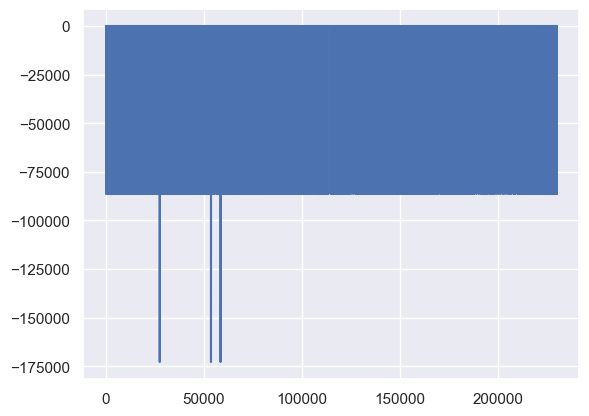

In [30]:
df_tweets["timestamp"].diff().plot()

In [31]:
np.sort(df_tweets["timestamp"])

array([1.5776640e+09, 1.5776640e+09, 1.5777504e+09, ..., 1.6663104e+09,
       1.6663104e+09, 1.6663104e+09])

In [32]:
ser_test_cont_tweet = pd.Series(np.diff((np.sort(df_tweets["timestamp"].unique())).astype(np.int64)) == 24*3600)
ser_test_cont_tweet.value_counts()

True     1020
False       3
dtype: int64

In [33]:
if  test_time_continuity(df_tweets) is False:
    print("No time continuity in df_tweets!")
    ser_test_cont_tweet = (df_tweets["timestamp"].diff() < -100000)
    print(ser_test_cont_tweet.value_counts())
else:
    print("OK : df_tweets for all calendar dates")

Time gap!
No time continuity in df_tweets!
False    229854
True          3
Name: timestamp, dtype: int64


## Calculate the correlation between the price of $OCEAN and the number of tweets containing "$OCEAN". 
What conclusions can be drawn from this correlation?

In [34]:
df_tweets

,id,reply_to,video,retweet,link,cashtags,hashtags,retweets_count,replies_count,photos,...,timezone,time,date,created_at,name,thumbnail,quote_url,time_utc,date_utc,timestamp
0,1583608299085500416,"[{'screen_name': 'JakeGagain', 'name': 'Jake G...",0,False,https://twitter.com/Mxyzptlk07/status/15836082...,['ocean'],"['data', 'web3']",0,0,[],...,300,02:56:55,2022-10-22,2022-10-22 02:56:55 GTB (heure d’été),Mxyzptlk,NaN,NaN,2022-10-21 23:56:55+00:00,2022-10-21,1.666310e+09
1,1583607565543669761,[],0,False,https://twitter.com/Mxyzptlk07/status/15836075...,['ocean'],"['datascientists', 'buidl', 'anewdataeconomy']",0,0,[],...,300,02:54:00,2022-10-22,2022-10-22 02:54:00 GTB (heure d’été),Mxyzptlk,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:54:00+00:00,2022-10-21,1.666310e+09
2,1583603064044367872,[],0,False,https://twitter.com/Moonhodler2/status/1583603...,['ocean'],['data'],0,0,[],...,300,02:36:07,2022-10-22,2022-10-22 02:36:07 GTB (heure d’été),MOONHODLER,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:36:07+00:00,2022-10-21,1.666310e+09
3,1583598008511664128,"[{'screen_name': 'CryptoGemsCom', 'name': 'The...",0,False,https://twitter.com/rjgaurav338/status/1583598...,"['ocean', 'bnb', 'eth']",[],0,0,[],...,300,02:16:01,2022-10-22,2022-10-22 02:16:01 GTB (heure d’été),rikdbxs,NaN,NaN,2022-10-21 23:16:01+00:00,2022-10-21,1.666310e+09
4,1583595987851173888,"[{'screen_name': 'cryptoworld202', 'name': 'Cr...",1,False,https://twitter.com/StringerBcoiner/status/158...,"['ocean', 'ltc', 'ngm', 'dafi', 'esek', 'enok'...","['ngm', 'dafi', 'ngm']",0,1,['https://pbs.twimg.com/media/FfoQJTUWQAMjfYy....,...,300,02:07:59,2022-10-22,2022-10-22 02:07:59 GTB (heure d’été),StringerBitcoiner,https://pbs.twimg.com/media/FfoQJTUWQAMjfYy.jpg,NaN,2022-10-21 23:07:59+00:00,2022-10-21,1.666310e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229852,1211845595977019392,[],0,False,https://twitter.com/Mojo_Crypto_BTC/status/121...,"['xrp', 'perl', 'nrg', 'ocean']",[],0,0,[],...,300,05:04:39,2019-12-31,2019-12-31 05:04:39 GTB,🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL,NaN,NaN,2019-12-31 02:04:39+00:00,2019-12-31,1.577750e+09
229853,1211830366513901568,"[{'screen_name': 'DaveCryptos', 'name': 'Dave ...",0,False,https://twitter.com/harmoniccapital/status/121...,['ocean'],[],0,0,[],...,300,04:04:08,2019-12-31,2019-12-31 04:04:08 GTB,Harmonic Capital,NaN,NaN,2019-12-31 01:04:08+00:00,2019-12-31,1.577750e+09
229854,1211818209738817536,[],0,False,https://twitter.com/bakeobits/status/121181820...,"['ins', 'ocean', 'ins']",[],0,2,[],...,300,03:15:50,2019-12-31,2019-12-31 03:15:50 GTB,ShillSilverstein.kek 📈👑📉,NaN,NaN,2019-12-31 00:15:50+00:00,2019-12-31,1.577750e+09
229855,1211808120659300352,[],1,False,https://twitter.com/bakeobits/status/121180812...,['ocean'],[],0,2,['https://pbs.twimg.com/media/ENE1D4GUYAAWcVh....,...,300,02:35:44,2019-12-31,2019-12-31 02:35:44 GTB,ShillSilverstein.kek 📈👑📉,https://pbs.twimg.com/media/ENE1D4GUYAAWcVh.jpg,NaN,2019-12-30 23:35:44+00:00,2019-12-30,1.577664e+09


### Select data with cash tags

In [35]:
def fun_find_cash(list_str):
    return "ocean" in list_str
df_tweets["cash"] = df_tweets["cashtags"].apply(fun_find_cash)
df_tweets["cash"].value_counts()

True     229773
False        84
Name: cash, dtype: int64

In [36]:
df_tweets[["cash", "date_utc"]].groupby("date_utc").count()

,cash
date_utc,
2019-12-30,2
2019-12-31,35
2020-01-01,37
2020-01-02,52
2020-01-03,39
...,...
2022-10-17,157
2022-10-18,686
2022-10-19,273


Check if everyday a tweet with $OCEAN tags occurs

In [37]:
nb_dates = df_tweets["date_utc"].nunique()
print("nb_dates: ", nb_dates)
ser_nb_cash = df_tweets[
        ["cash", "date_utc"]
    ].groupby("date_utc",
    group_keys=False).apply(lambda x: np.any(x["cash"])).value_counts()
print(ser_nb_cash)
assert ser_nb_cash[True] == nb_dates, "NOT everyday, a tweet with $OCEAN tags occurs !"
print("OK :  everyday, a tweet with $OCEAN tags occurs !")

nb_dates:  1024
True    1024
dtype: int64
OK :  everyday, a tweet with $OCEAN tags occurs !


### Count nb tweets

In [38]:
df_nb_tweets = df_tweets[df_tweets["cash"] == True][["id", "date_utc"]].groupby("date_utc").count()
df_nb_tweets.rename(columns={"id":"nb_tweets"}, inplace=True)
df_nb_tweets

,nb_tweets
date_utc,
2019-12-30,2
2019-12-31,35
2020-01-01,37
2020-01-02,52
2020-01-03,38
...,...
2022-10-17,156
2022-10-18,686
2022-10-19,273


In [39]:
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704,1.557101e+09
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049,1.557187e+09
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657,1.557274e+09
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438,1.557360e+09
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215,1.557446e+09
...,...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755,1.684973e+09
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463,1.685059e+09
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248,1.685146e+09
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566,1.685232e+09


### Add insights about prices

In [40]:
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704,1.557101e+09
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049,1.557187e+09
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657,1.557274e+09
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438,1.557360e+09
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215,1.557446e+09
...,...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755,1.684973e+09
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463,1.685059e+09
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248,1.685146e+09
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566,1.685232e+09


In [41]:
df_prices["pc_var"] = 100 * ( df_prices["Close"]  - df_prices["Open"] ) / df_prices["Open"]
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
0,2019-05-06,0.030366,0.032274,0.029264,0.030010,0.030010,409704,1.557101e+09,-1.172364
1,2019-05-07,0.030004,0.034073,0.029316,0.032430,0.032430,444049,1.557187e+09,8.085589
2,2019-05-08,0.032356,0.032356,0.027614,0.030407,0.030407,357657,1.557274e+09,-6.023612
3,2019-05-09,0.030359,0.031349,0.025541,0.027187,0.027187,328438,1.557360e+09,-10.448302
4,2019-05-10,0.027153,0.028078,0.023804,0.024751,0.024751,345215,1.557446e+09,-8.846168
...,...,...,...,...,...,...,...,...,...
1480,2023-05-25,0.327049,0.334983,0.318326,0.325028,0.325028,15927755,1.684973e+09,-0.617950
1481,2023-05-26,0.325024,0.346889,0.324414,0.346289,0.346289,21174463,1.685059e+09,6.542594
1482,2023-05-27,0.346320,0.366628,0.345204,0.350783,0.350783,33179248,1.685146e+09,1.288693
1483,2023-05-28,0.350814,0.365085,0.349344,0.358697,0.358697,18058566,1.685232e+09,2.247060


Levels of price variation : level_stat_price :
- neutral : var mean - 1 std < var price < var mean + 1 std
- bearish : var price < var mean - std
- bullish : var price > var mean + std

In [42]:
list_level_stat_price = ["bearish", "neutral", "bullish"]
mean_pc_var = df_prices["pc_var"].mean()
print("mean_pc_var: ", mean_pc_var)
std_pc_var = df_prices["pc_var"].std()
print("std_pc_var: ", std_pc_var)

def fun_level_stat_price(pc_var):
    if (mean_pc_var - std_pc_var < pc_var) & (pc_var < (mean_pc_var + std_pc_var)):
        return "neutral"
    elif (mean_pc_var - std_pc_var > pc_var):
        return "bearish"
    else:
        return "bullish"
df_prices["level_stat_price"] = df_prices["pc_var"].apply(fun_level_stat_price)
df_prices["level_stat_price"].value_counts()

mean_pc_var:  0.5045419850808329
std_pc_var:  8.221292169357758


neutral    1153
bearish     166
bullish     166
Name: level_stat_price, dtype: int64

Another level more "in house" : level_price :
- normal : price var < 3+/- 3%
- decline : -7% < price var <= -3%
- fall : price var <= -7%
- rise : +7% > price var >= +3%
- surge : price var >= +7%

In [43]:
list_level_price = ["fall", "decline", "neutral", "rise", "surge"]
def fun_level_price(pc_var):
    if (-3 < pc_var) & (pc_var < 3):
        return "neutral"
    elif ( -7 < pc_var) & (pc_var <= -3):
        return "decline"
    elif ( pc_var <= -7):
        return "fall"  
    elif ( 7 > pc_var) & (pc_var >= 3):
        return "rise"            
    else:
        return "surge"

df_prices["level_price"] = df_prices["pc_var"].apply(fun_level_price)
df_prices["level_price"].value_counts()

neutral    574
decline    257
rise       241
surge      220
fall       193
Name: level_price, dtype: int64

### Add insights about nb tweets

In [44]:
df_nb_tweets

,nb_tweets
date_utc,
2019-12-30,2
2019-12-31,35
2020-01-01,37
2020-01-02,52
2020-01-03,38
...,...
2022-10-17,156
2022-10-18,686
2022-10-19,273


In [45]:
list_level_tweets = ["low_nb_tweet", "normal_nb_tweet", "high_nb_tweet"]
mean_nb_tweets = df_nb_tweets["nb_tweets"].mean()
print("mean_nb_tweets: ", mean_nb_tweets)
std_nb_tweets = df_nb_tweets["nb_tweets"].std()
print("std_nb_tweets: ", std_nb_tweets)
print("low_nb_tweet:")
print(f"0 - {mean_nb_tweets - std_nb_tweets/2}")
print("normal_nb_tweet:")
print(f"{mean_nb_tweets - std_nb_tweets/2} - {mean_nb_tweets + std_nb_tweets/2}")
print("high_nb_tweet:")
print(f"{mean_nb_tweets + std_nb_tweets/2} - inf")


def fun_level_nb_tweet(nb_tweets):
    if (mean_nb_tweets - std_nb_tweets/2 < nb_tweets) & (nb_tweets < (mean_nb_tweets + std_nb_tweets/2)):
        return "normal_nb_tweet"
    elif (mean_nb_tweets - std_nb_tweets/2 > nb_tweets):
        return "low_nb_tweet"
    else:
        return "high_nb_tweet"
df_nb_tweets["level_tweets"] = df_nb_tweets["nb_tweets"].apply(fun_level_nb_tweet)
df_nb_tweets["level_tweets"].value_counts()

mean_nb_tweets:  224.3876953125
std_nb_tweets:  205.75672764843276
low_nb_tweet:
0 - 121.50933148828362
normal_nb_tweet:
121.50933148828362 - 327.26605913671636
high_nb_tweet:
327.26605913671636 - inf


normal_nb_tweet    428
low_nb_tweet       365
high_nb_tweet      231
Name: level_tweets, dtype: int64

Nb tweets over 30 days & mean daily tweet over 30 days:

In [46]:
ser_month  = df_nb_tweets["nb_tweets"].rolling(30).sum()

df_nb_tweets["nb_tweets_30D"] = ser_month

ser_month  = df_nb_tweets["nb_tweets"].rolling(30).mean()

df_nb_tweets["nb_tweets_mean_30D"] = ser_month

### merge data

In [47]:
df_nb = df_nb_tweets.merge(df_prices, how='inner', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price
238,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge
239,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge
240,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise
241,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall
242,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral
1261,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge
1262,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral
1263,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral


### Insights

In [48]:
df_nb.describe()

,nb_tweets,nb_tweets_30D,nb_tweets_mean_30D,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
count,1024.000000,995.000000,995.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.024000e+03,1.024000e+03,1024.000000
mean,224.387695,6825.584925,227.519497,0.486282,0.515553,0.458556,0.486476,0.486476,3.423628e+07,1.621932e+09,0.481513
std,205.756728,5053.129696,168.437657,0.389896,0.414562,0.367286,0.389883,0.389883,4.044728e+07,2.564096e+07,7.777951
min,1.000000,805.000000,26.833333,0.019931,0.024722,0.017603,0.020029,0.020029,1.632125e+06,1.577664e+09,-54.595069
25%,97.000000,3808.000000,126.933333,0.165172,0.172069,0.159381,0.165168,0.165168,1.278643e+07,1.599761e+09,-3.833254
50%,157.000000,4924.000000,164.133333,0.432268,0.454014,0.409697,0.432423,0.432423,2.317279e+07,1.621858e+09,0.345004
75%,293.250000,9643.500000,321.450000,0.683909,0.732825,0.627980,0.683721,0.683721,4.386585e+07,1.644127e+09,4.250609
max,1326.000000,24374.000000,812.466667,1.818558,1.941328,1.719507,1.817588,1.817588,5.525757e+08,1.666310e+09,55.099021


#### Close price

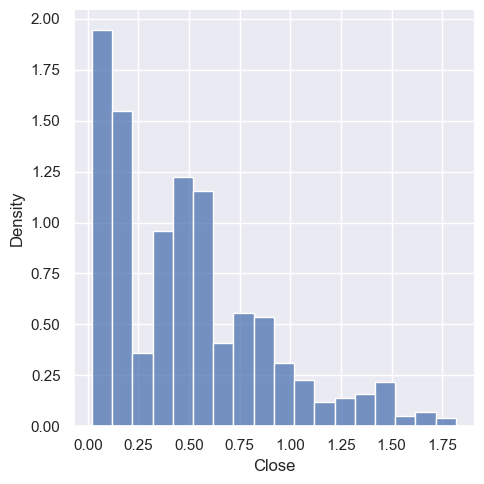

In [49]:
sns.displot(df_nb, x="Close",stat="density")

<AxesSubplot: xlabel='Close'>

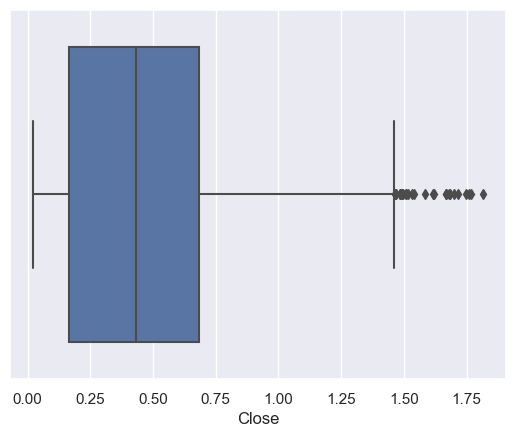

In [50]:
sns.boxplot(x=df_nb["Close"])

#### nb tweets

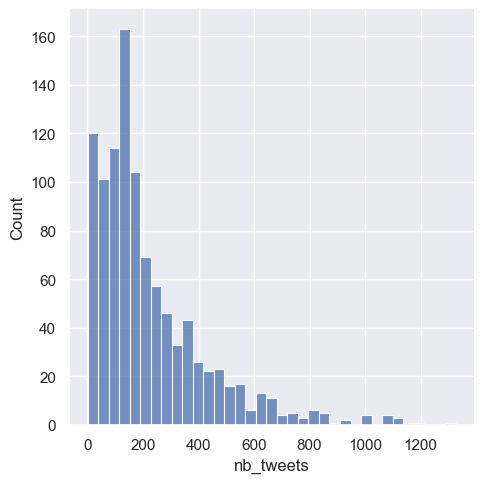

In [51]:
sns.displot(df_nb, x="nb_tweets")

<AxesSubplot: xlabel='nb_tweets'>

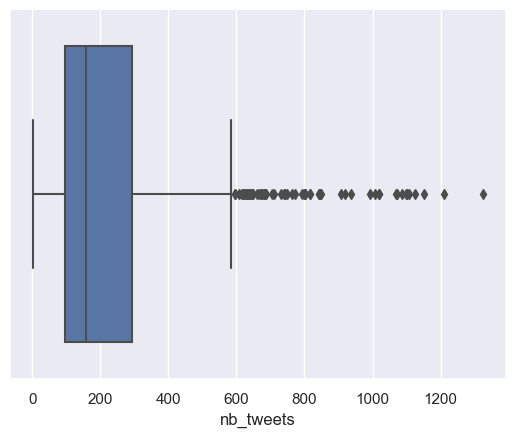

In [52]:
sns.boxplot(x=df_nb["nb_tweets"])

#### relation between Close price and nb tweets

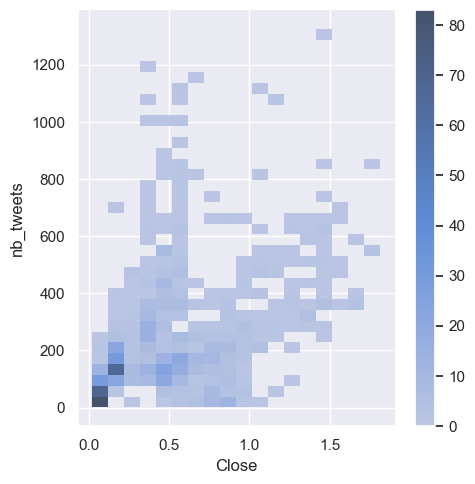

In [53]:
sns.displot(df_nb, x="Close", y="nb_tweets", cbar=True)

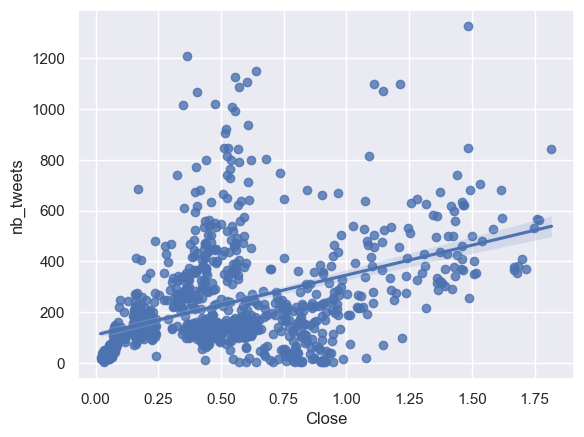

In [54]:
sns.regplot(x="Close", y="nb_tweets", data=df_nb);

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_48356/1150079040.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_nb.corr()


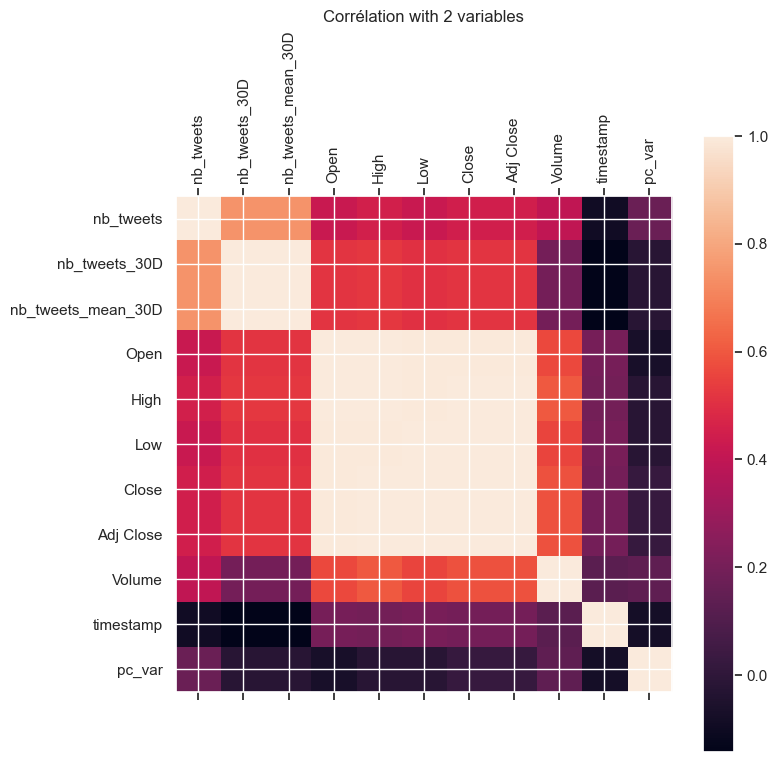

In [55]:
# Calculer la matrice de corrélation
corr_matrix = df_nb.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()

In [56]:
print("Corr coef nb_tweets vs Close: ",  corr_matrix.at["nb_tweets", "Close"])
print("Corr coef nb_tweets vs pc_var: ",  corr_matrix.at["nb_tweets", "pc_var"])
print("Corr coef nb_tweets over 30 days vs Close: ",  corr_matrix.at["nb_tweets_30D", "Close"])
print("Corr coef nb_tweets over 30 days vs pc_var: ",  corr_matrix.at["nb_tweets_30D", "pc_var"])
print("Corr coef mean daily nb_tweets over 30 days vs Close: ",  corr_matrix.at["nb_tweets_mean_30D", "Close"])
print("Corr coef mean daily nb_tweets over 30 days  vs pc_var: ",  corr_matrix.at["nb_tweets_mean_30D", "pc_var"])

Corr coef nb_tweets vs Close:  0.4465065616048417
Corr coef nb_tweets vs pc_var:  0.17082374323454366
Corr coef nb_tweets over 30 days vs Close:  0.5170340902313064
Corr coef nb_tweets over 30 days vs pc_var:  -0.02120182127190575
Corr coef mean daily nb_tweets over 30 days vs Close:  0.5170340902313062
Corr coef mean daily nb_tweets over 30 days  vs pc_var:  -0.021201821271905917


Not really corrrelated

#### Time evolution

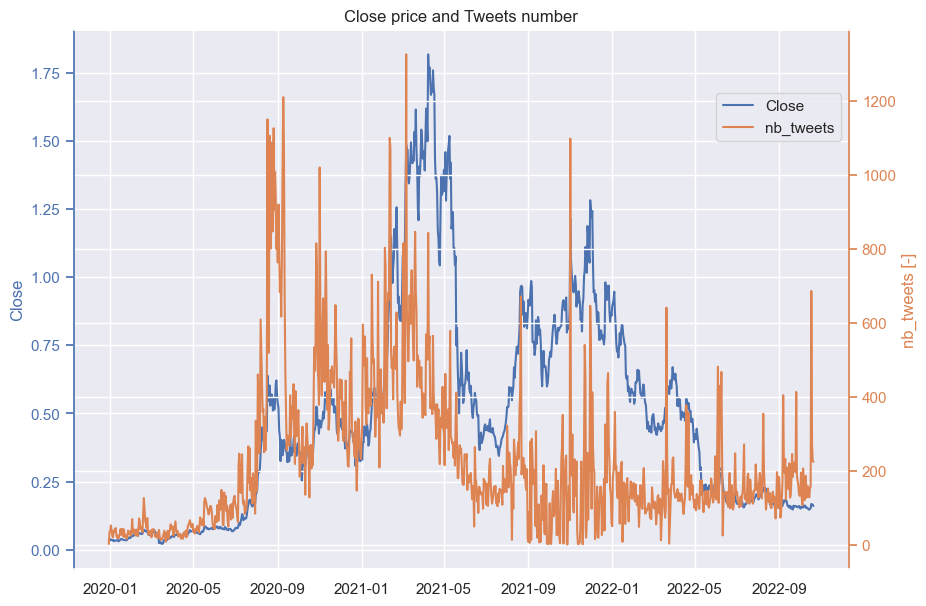

In [57]:
fig, ax1 = plt.subplots()
fig.set_size_inches([10,7])
ax1.plot(df_nb["Date"].astype(np.datetime64),df_nb["Close"])
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_title('Close price and Tweets number')
ax2 = ax1.twinx()
ax2.plot(df_nb["Date"].astype(np.datetime64),df_nb["nb_tweets"],'C1')
ax2.set_ylabel('nb_tweets [-]', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')
fig.legend(['Close',"nb_tweets"], bbox_to_anchor=(0.9, 0.8))
plt.show()

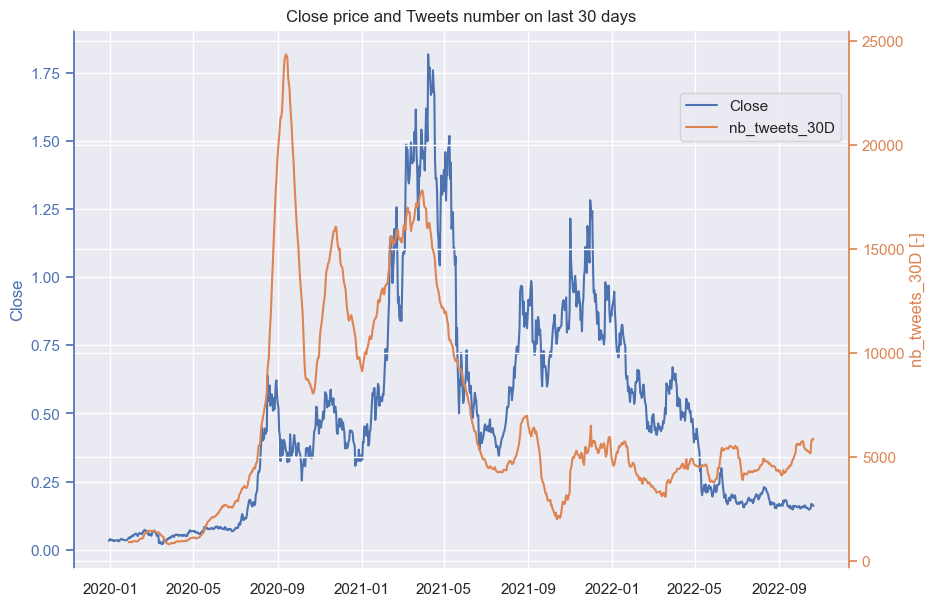

In [58]:
fig, ax1 = plt.subplots()
fig.set_size_inches([10,7])
ax1.plot(df_nb["Date"].astype(np.datetime64),df_nb["Close"])
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_title('Close price and Tweets number on last 30 days')
ax2 = ax1.twinx()
ax2.plot(df_nb["Date"].astype(np.datetime64),df_nb["nb_tweets_30D"],'C1')
ax2.set_ylabel('nb_tweets_30D [-]', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')
fig.legend(['Close',"nb_tweets_30D"], bbox_to_anchor=(0.9, 0.8))
plt.show()

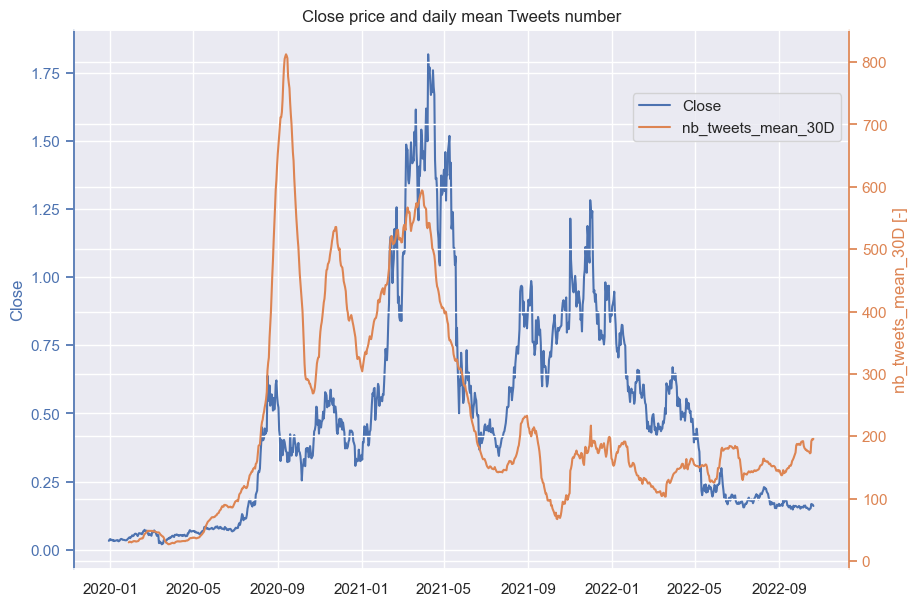

In [59]:
fig, ax1 = plt.subplots()
fig.set_size_inches([10,7])
ax1.plot(df_nb["Date"].astype(np.datetime64),df_nb["Close"])
ax1.set_ylabel('Close', color='C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_title('Close price and daily mean Tweets number')
ax2 = ax1.twinx()
ax2.plot(df_nb["Date"].astype(np.datetime64),df_nb["nb_tweets_mean_30D"],'C1')
ax2.set_ylabel('nb_tweets_mean_30D [-]', color='C1')
ax2.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')
fig.legend(['Close',"nb_tweets_mean_30D"], bbox_to_anchor=(0.9, 0.8))
plt.show()

In [60]:
df_nb

,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price
238,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge
239,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge
240,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise
241,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall
242,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral
1261,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge
1262,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral
1263,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral


#### Price variation in a day

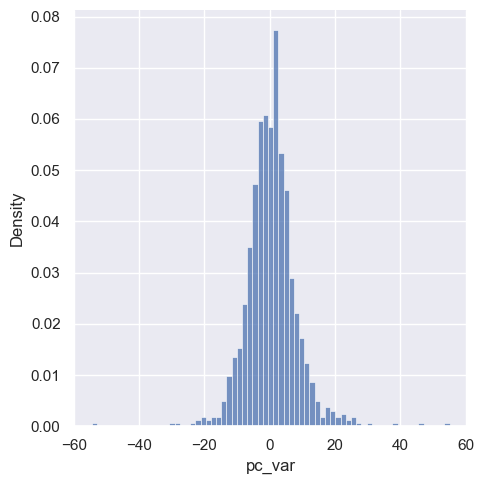

In [61]:
sns.displot(df_nb, x="pc_var",stat="density")

<AxesSubplot: xlabel='pc_var'>

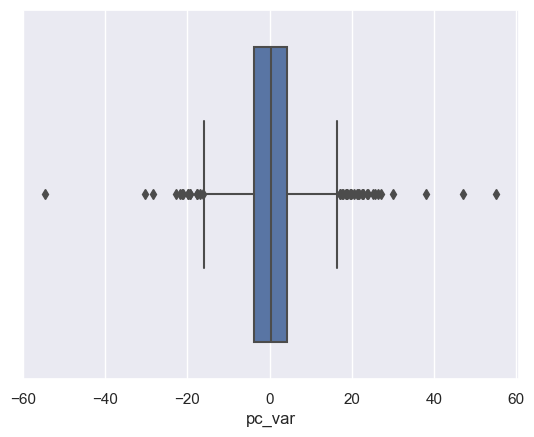

In [62]:
sns.boxplot(x=df_nb["pc_var"])

<AxesSubplot: xlabel='pc_var'>

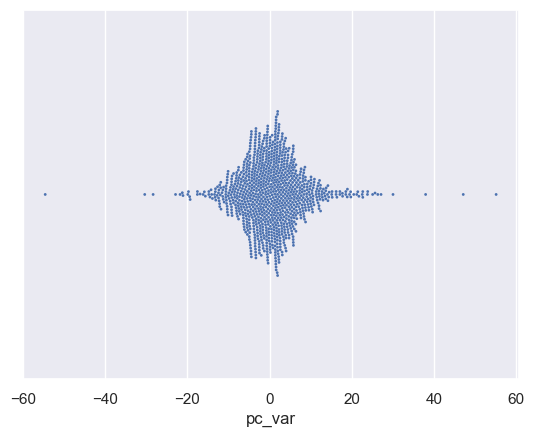

In [63]:
sns.swarmplot(x=df_nb["pc_var"], size=2)

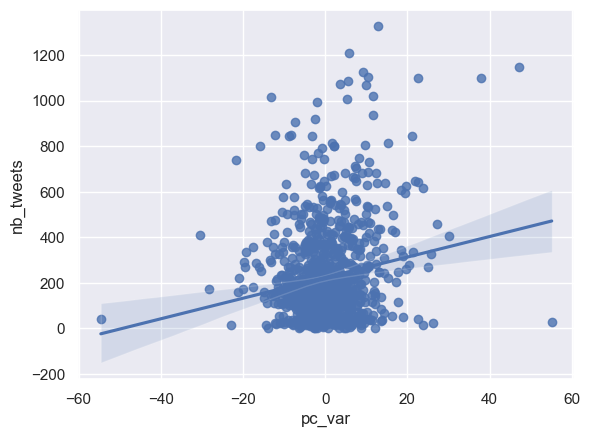

In [64]:
sns.regplot(x="pc_var", y="nb_tweets", data=df_nb);

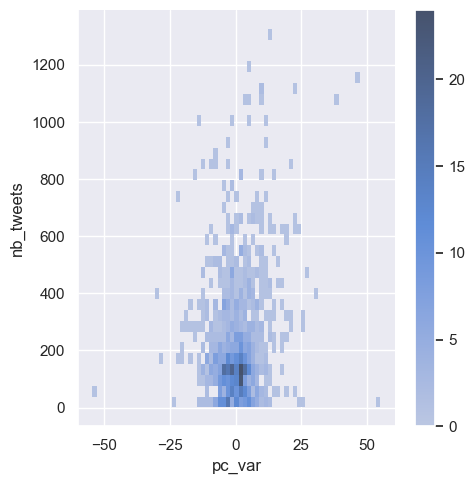

In [65]:
sns.displot(df_nb, x="pc_var", y="nb_tweets", cbar=True)

#### tweets level

In [66]:
def fun_level_nb_tweets(nb):
    return str(100*round(nb/100))
df_nb["tweet_level"] = df_nb["nb_tweets"].apply(fun_level_nb_tweets)
list_tweet_level = sorted(list(df_nb["tweet_level"].unique()), key=int)
print("list_tweet_level: ", list_tweet_level)
df_nb

list_tweet_level:  ['0', '100', '200', '300', '400', '500', '600', '700', '800', '900', '1000', '1100', '1200', '1300']


,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


In [67]:
np.sort(df_nb["tweet_level"].unique())

array(['0', '100', '1000', '1100', '1200', '1300', '200', '300', '400',
       '500', '600', '700', '800', '900'], dtype=object)

<AxesSubplot: xlabel='tweet_level', ylabel='Count'>

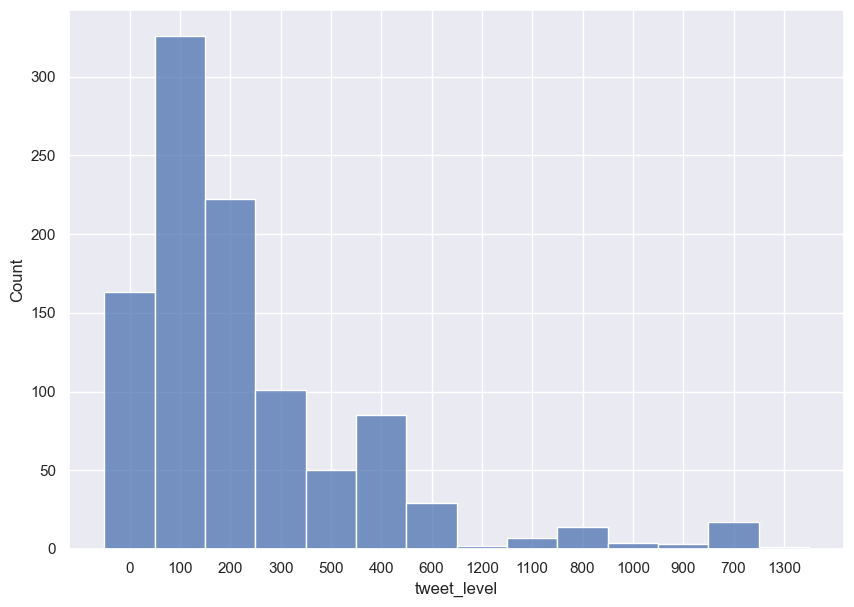

In [68]:
fig = plt.figure(figsize=(10, 7))
#ax = fig.gca()
sns.histplot(df_nb, x="tweet_level")

<AxesSubplot: xlabel='pc_var', ylabel='tweet_level'>

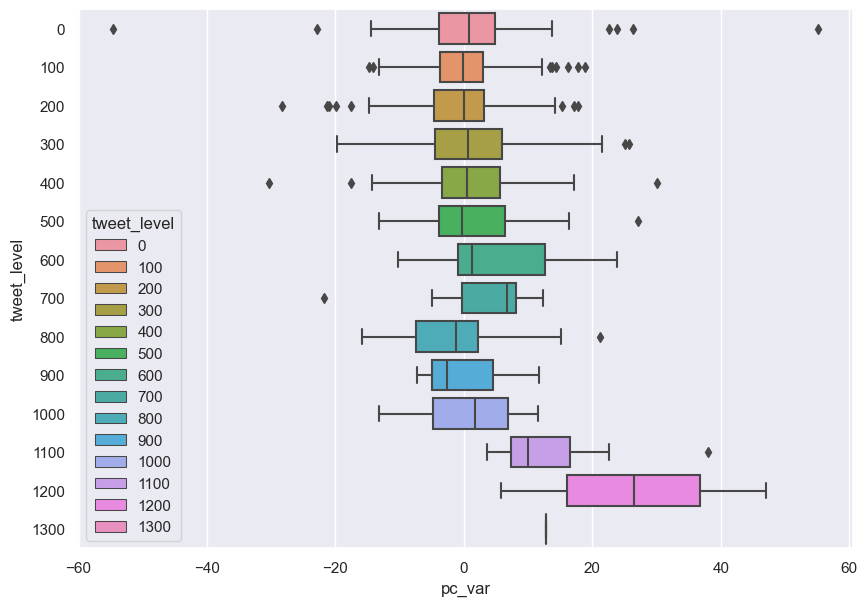

In [69]:
#sns.boxplot(data=df_nb, x="pc_var", y="level")
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="pc_var", y="tweet_level", 
    hue="tweet_level", dodge=False,
    order=list_tweet_level, hue_order=list_tweet_level
)


/Users/gregory/miniforge3/envs/ocean_tf_nlp/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 22.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='pc_var', ylabel='tweet_level'>

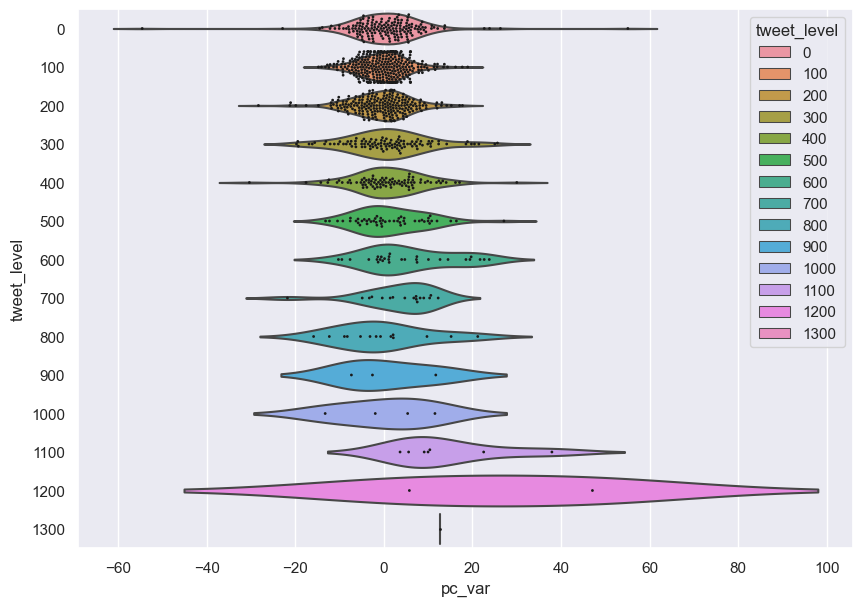

In [70]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="pc_var", y="tweet_level", hue="tweet_level", 
               order=list_tweet_level, hue_order=list_tweet_level, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="pc_var", y="tweet_level", color="k", 
              order=list_tweet_level,
              size=2, ax=ax)

#### Tweets level stat

<AxesSubplot: xlabel='level_tweets', ylabel='Count'>

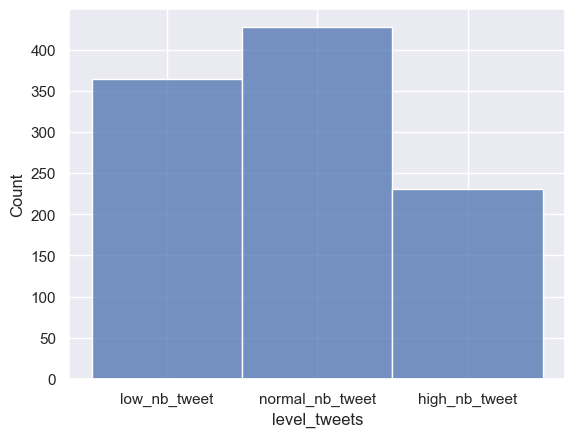

In [71]:
#fig = plt.figure(figsize=(10, 7))
#ax = fig.gca()
sns.histplot(df_nb, x="level_tweets")

<AxesSubplot: xlabel='pc_var', ylabel='level_tweets'>

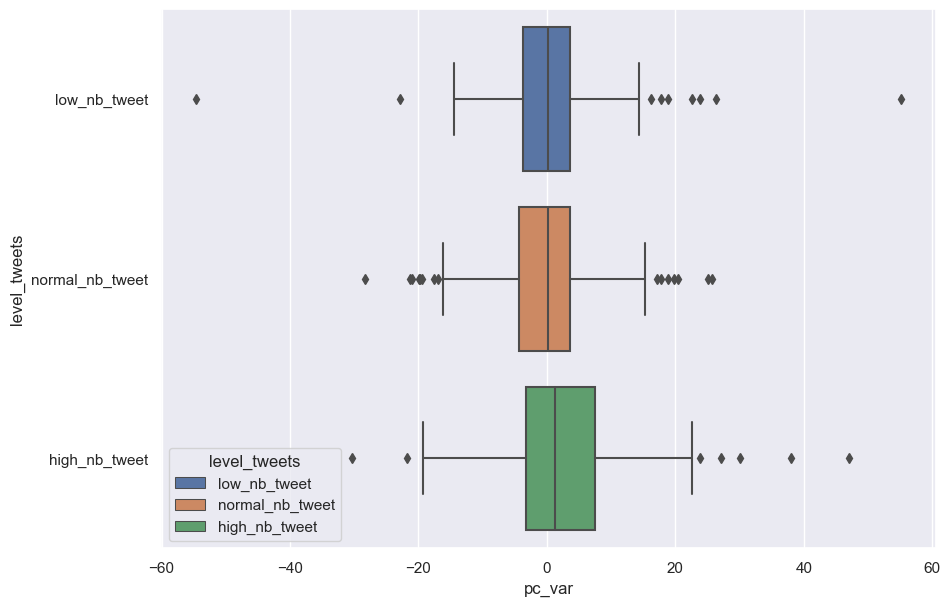

In [72]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="pc_var", y="level_tweets", 
    hue="level_tweets", dodge=False,
    order=list_level_tweets, hue_order=list_level_tweets
)

<AxesSubplot: xlabel='pc_var', ylabel='level_tweets'>

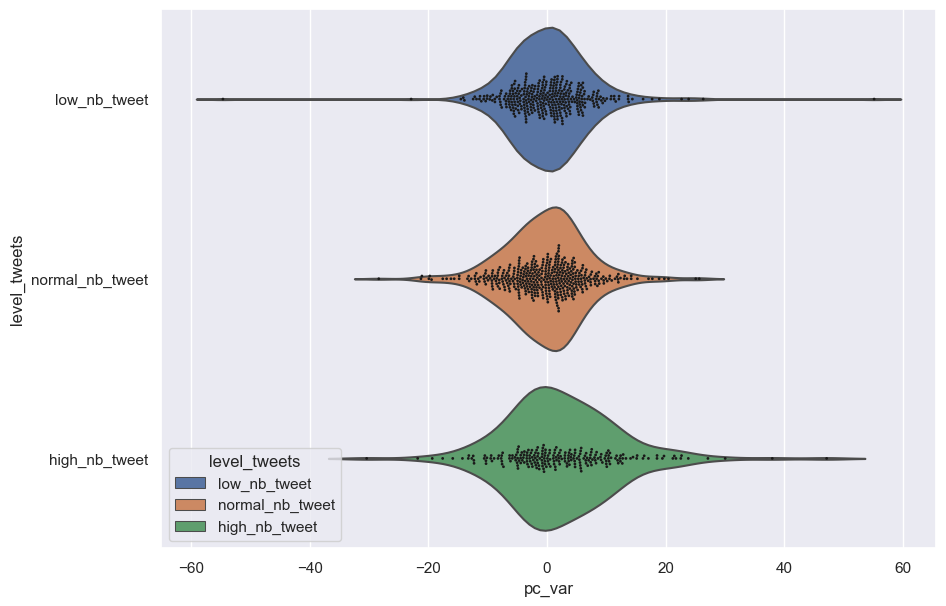

In [73]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="pc_var", y="level_tweets", hue="level_tweets", 
               order=list_level_tweets, hue_order=list_level_tweets, 
               inner=None, dodge=False)
sns.swarmplot(data=df_nb, x="pc_var", y="level_tweets", color="k", 
              order=list_level_tweets,
              size=2, ax=ax)

#### price level

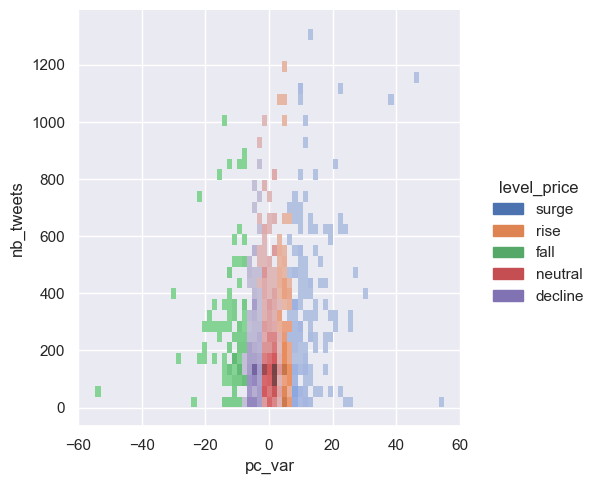

In [74]:
sns.displot(df_nb, x="pc_var", y="nb_tweets", hue="level_price")

<Figure size 1000x700 with 0 Axes>

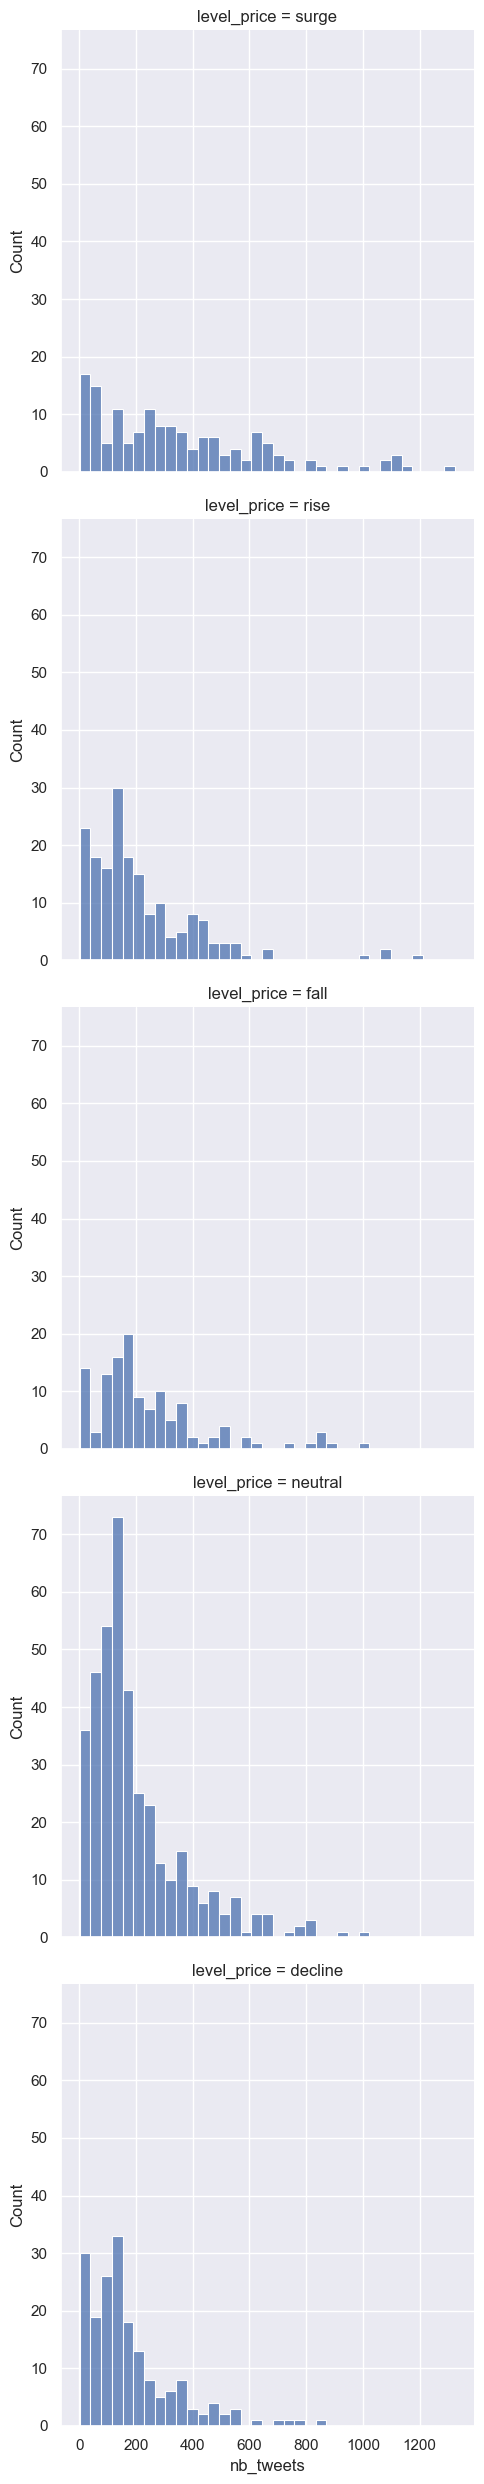

In [75]:
fig = plt.figure(figsize=(10, 7))
#ax = fig.gca()
sns.displot(df_nb, x="nb_tweets", row="level_price")

<AxesSubplot: xlabel='nb_tweets', ylabel='level_price'>

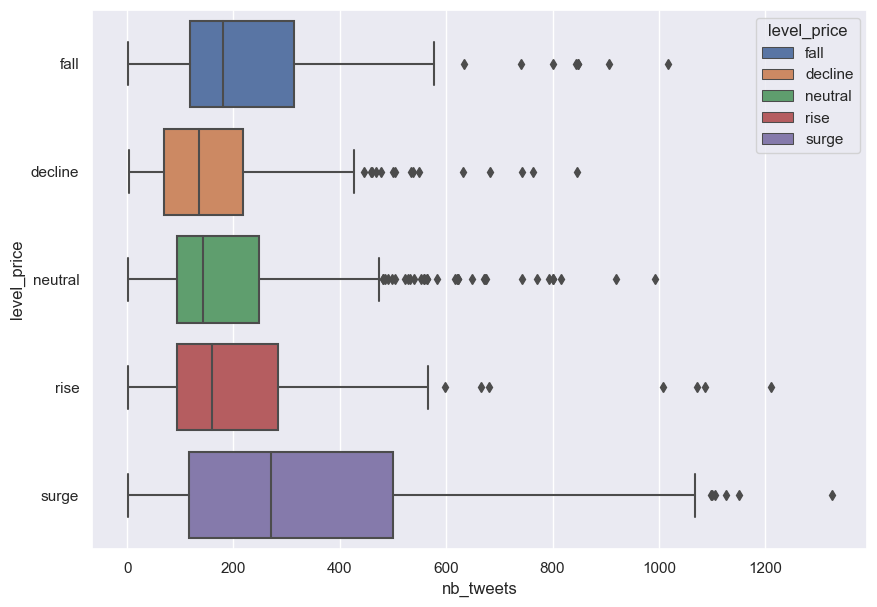

In [76]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="nb_tweets", y="level_price", 
    hue="level_price", dodge=False, 
    order=list_level_price, hue_order=list_level_price)

<AxesSubplot: xlabel='nb_tweets', ylabel='level_price'>

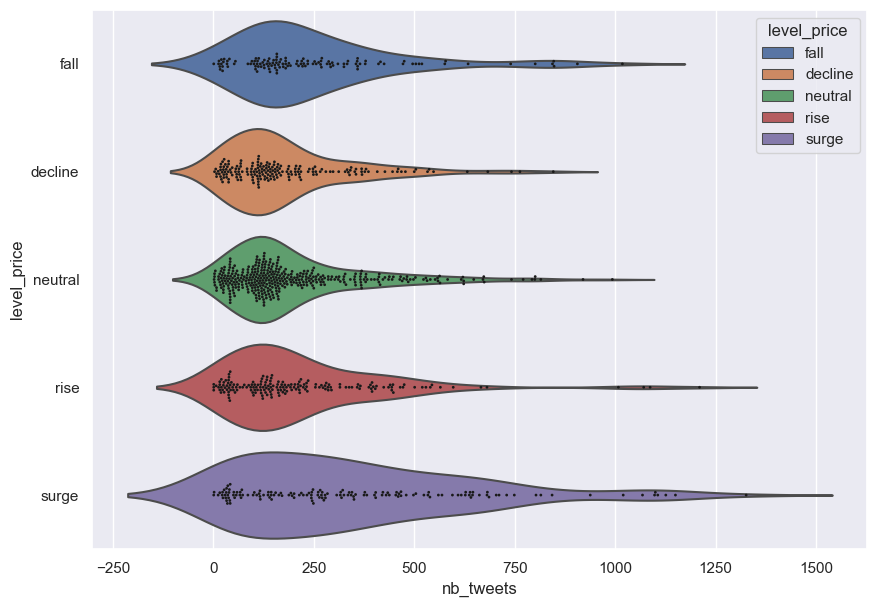

In [77]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="nb_tweets", y="level_price", hue="level_price", 
               order=list_level_price, hue_order=list_level_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="nb_tweets", y="level_price", color="k", 
              order=list_level_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_price', ylabel='nb_tweets'>

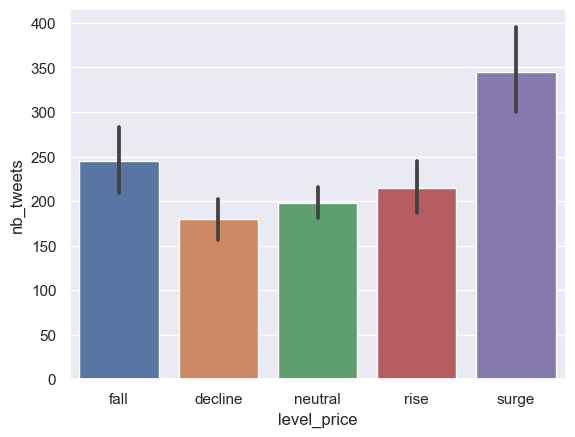

In [78]:
sns.barplot(data=df_nb, x="level_price", y="nb_tweets",
order=list_level_price)

#### price stat level 

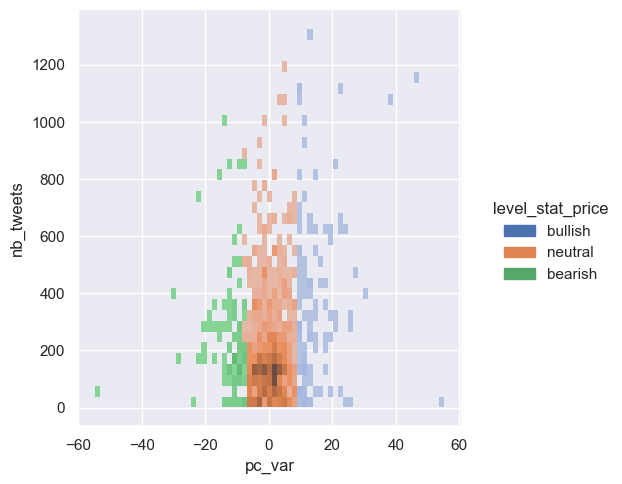

In [79]:
sns.displot(df_nb, x="pc_var", y="nb_tweets", hue="level_stat_price")

<Figure size 1000x800 with 0 Axes>

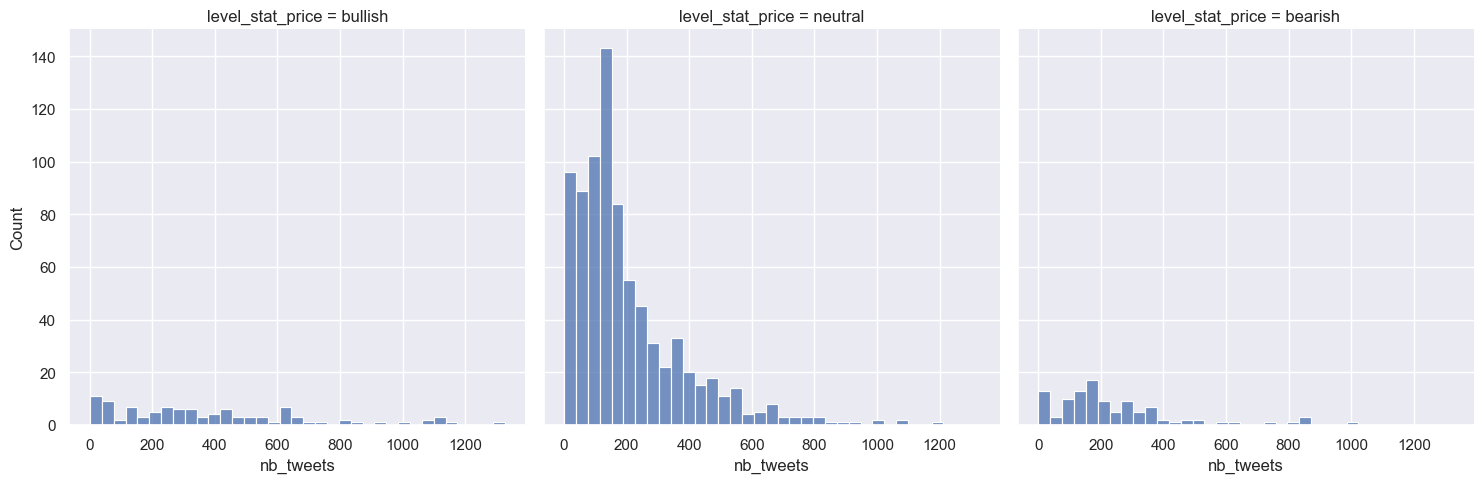

In [80]:
fig = plt.figure(figsize=(10, 8))
#ax = fig.gca()
sns.displot(df_nb, x="nb_tweets", col="level_stat_price")

<AxesSubplot: xlabel='nb_tweets', ylabel='level_stat_price'>

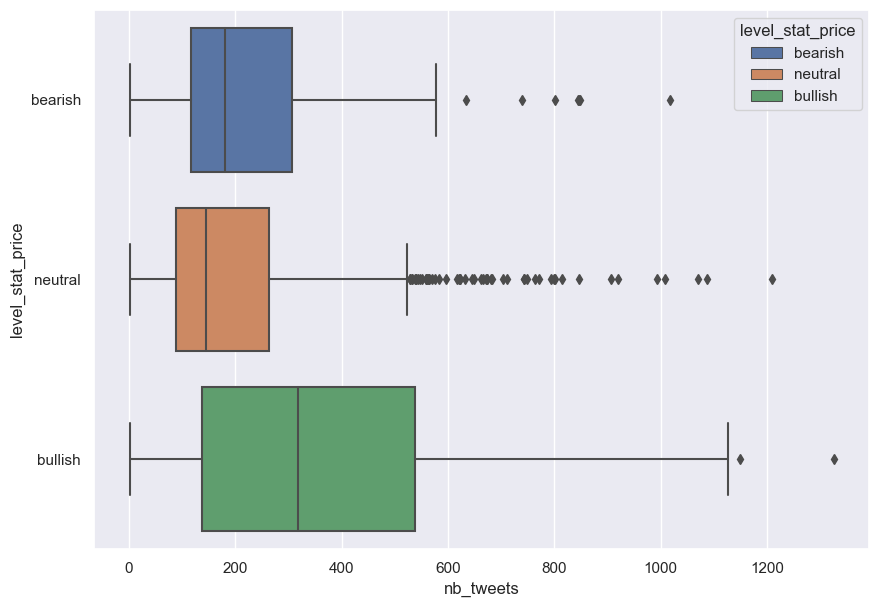

In [81]:
#sns.boxplot(data=df_nb, x="pc_var", y="level")
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="nb_tweets", y="level_stat_price", 
    hue="level_stat_price", dodge=False, 
    order=list_level_stat_price, hue_order=list_level_stat_price)

<AxesSubplot: xlabel='nb_tweets', ylabel='level_stat_price'>

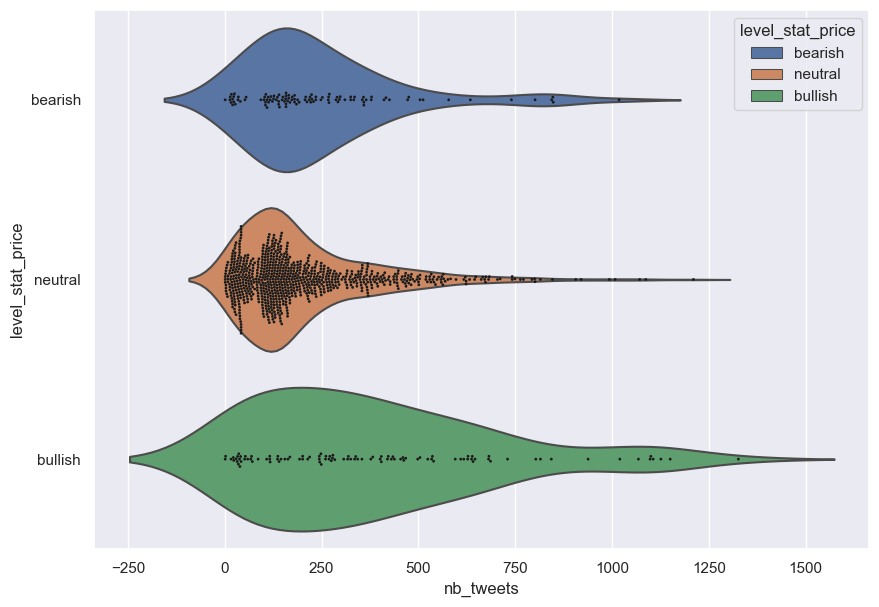

In [82]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="nb_tweets", y="level_stat_price", hue="level_stat_price", 
               order=list_level_stat_price, hue_order=list_level_stat_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="nb_tweets", y="level_stat_price", color="k", 
              order=list_level_stat_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_stat_price', ylabel='nb_tweets'>

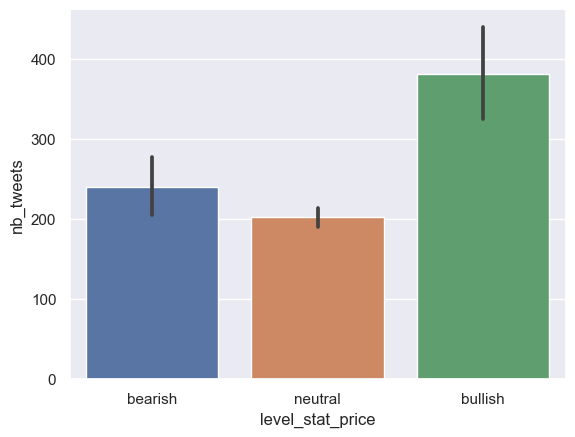

In [83]:
sns.barplot(data=df_nb, x="level_stat_price", y="nb_tweets",
order=list_level_stat_price)

- Number of tweets increase during Bearish and Bullish events (price variation)  
- More during bullish period

## Determine the correlation between the price of $OCEAN and the number of likes received by tweets containing "$OCEAN". 
What insights can be derived from this correlation?

### Sum Likes for all tweets in a day

In [84]:
df_nb_likes = df_tweets[df_tweets["cash"] == True][["likes_count", "date_utc"]].groupby("date_utc").sum()
df_nb_likes

,likes_count
date_utc,
2019-12-30,2
2019-12-31,634
2020-01-01,424
2020-01-02,246
2020-01-03,301
...,...
2022-10-17,644
2022-10-18,5204
2022-10-19,1618


In [85]:
df_nb

,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


### merge data

In [86]:
df_nb = df_nb_likes.merge(df_nb, how='inner', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,likes_count,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,2,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,634,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,424,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,246,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,301,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,644,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,5204,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,1618,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,847,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


### nb likes (insights)

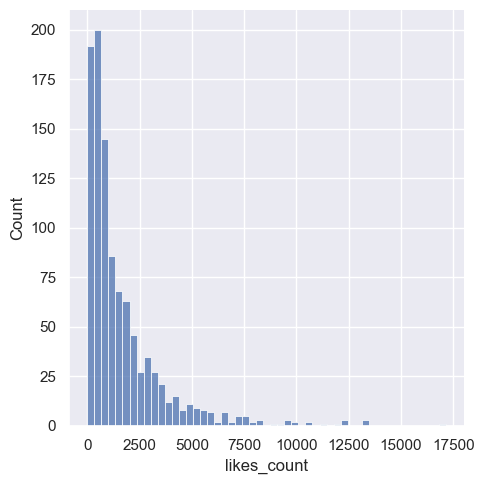

In [87]:
sns.displot(df_nb, x="likes_count")

<AxesSubplot: xlabel='likes_count'>

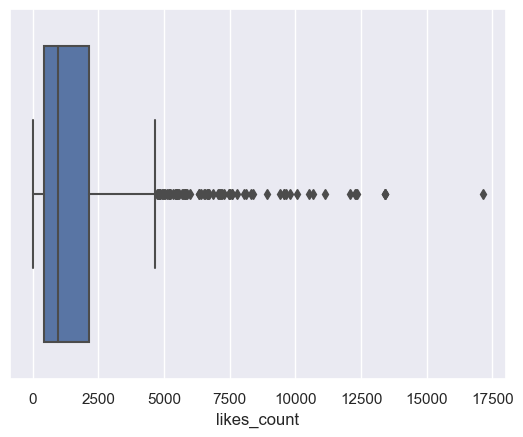

In [88]:
sns.boxplot(x=df_nb["likes_count"])

### Correlation matrix

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_48356/1150079040.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_nb.corr()


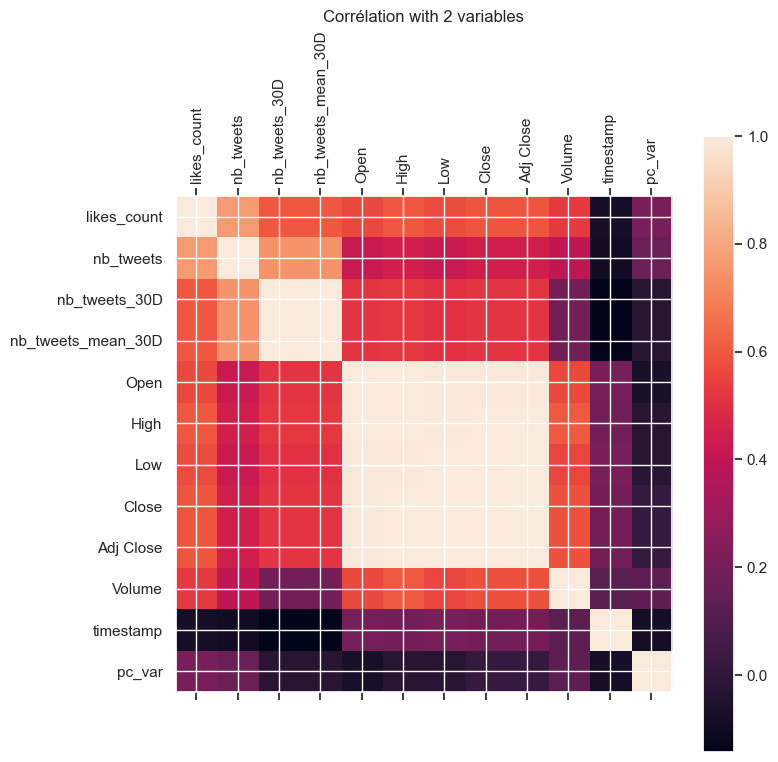

In [89]:
# Calculer la matrice de corrélation
corr_matrix = df_nb.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()

In [90]:
corr_matrix

,likes_count,nb_tweets,nb_tweets_30D,nb_tweets_mean_30D,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
likes_count,1.000000,0.765651,0.598796,0.598796,0.565089,0.599180,0.573586,0.598143,0.598143,0.528512,-0.074733,0.211415
nb_tweets,0.765651,1.000000,0.745825,0.745825,0.422540,0.454216,0.421602,0.446507,0.446507,0.400476,-0.089938,0.170824
nb_tweets_30D,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
nb_tweets_mean_30D,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
Open,0.565089,0.422540,0.516590,0.516590,1.000000,0.996081,0.995028,0.992612,0.992612,0.563991,0.202958,-0.070888
High,0.599180,0.454216,0.522484,0.522484,0.996081,1.000000,0.994099,0.996593,0.996593,0.604973,0.194758,-0.018357
Low,0.573586,0.421602,0.507271,0.507271,0.995028,0.994099,1.000000,0.996255,0.996255,0.556484,0.209858,-0.020019
Close,0.598143,0.446507,0.517034,0.517034,0.992612,0.996593,0.996255,1.000000,1.000000,0.586463,0.199715,0.022714
Adj Close,0.598143,0.446507,0.517034,0.517034,0.992612,0.996593,0.996255,1.000000,1.000000,0.586463,0.199715,0.022714
Volume,0.528512,0.400476,0.200727,0.200727,0.563991,0.604973,0.556484,0.586463,0.586463,1.000000,0.128360,0.140197


In [91]:
print("Corr coef nb likes vs Close: ",  corr_matrix.at["likes_count", "Close"])
print("Corr coef nb likes vs pc_var: ",  corr_matrix.at["likes_count", "pc_var"])

Corr coef nb likes vs Close:  0.5981432387534232
Corr coef nb likes vs pc_var:  0.21141516674978864


Correlation coef still not important :
- but more than with nb tweets 
- and equal to Volume corr.

### By price levels

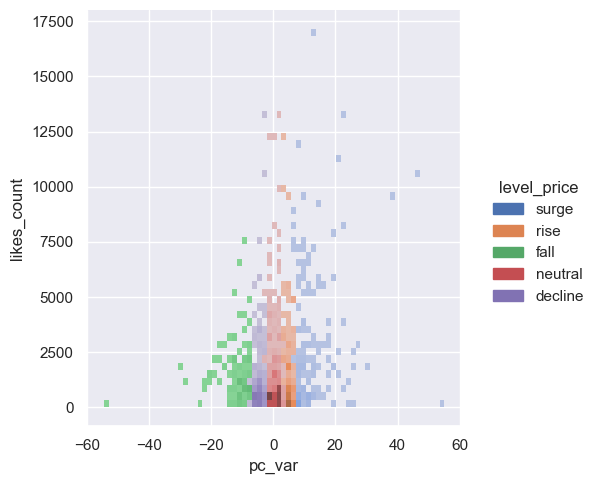

In [92]:
sns.displot(df_nb, x="pc_var", y="likes_count", hue="level_price")

<AxesSubplot: xlabel='likes_count', ylabel='level_price'>

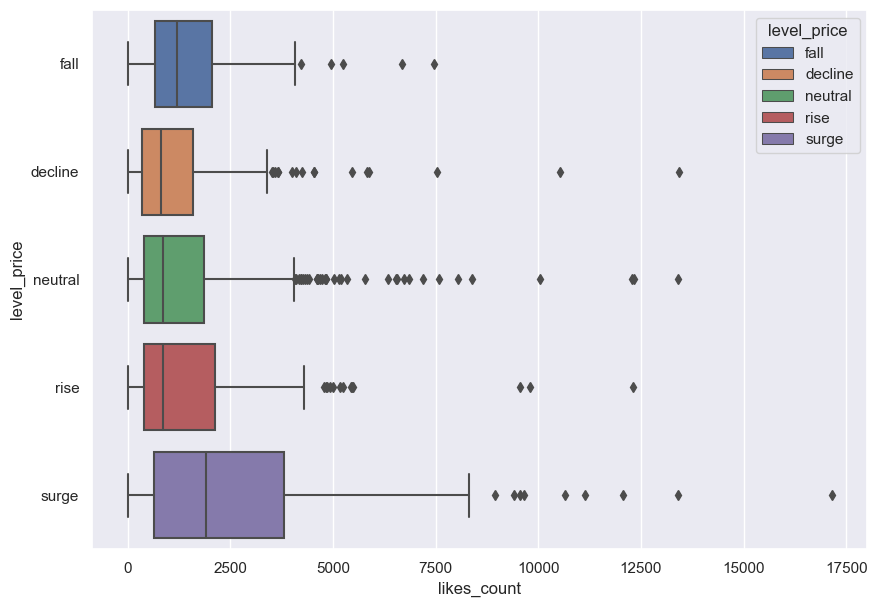

In [93]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="likes_count", y="level_price", 
    hue="level_price", dodge=False, 
    order=list_level_price, hue_order=list_level_price)

<AxesSubplot: xlabel='likes_count', ylabel='level_price'>

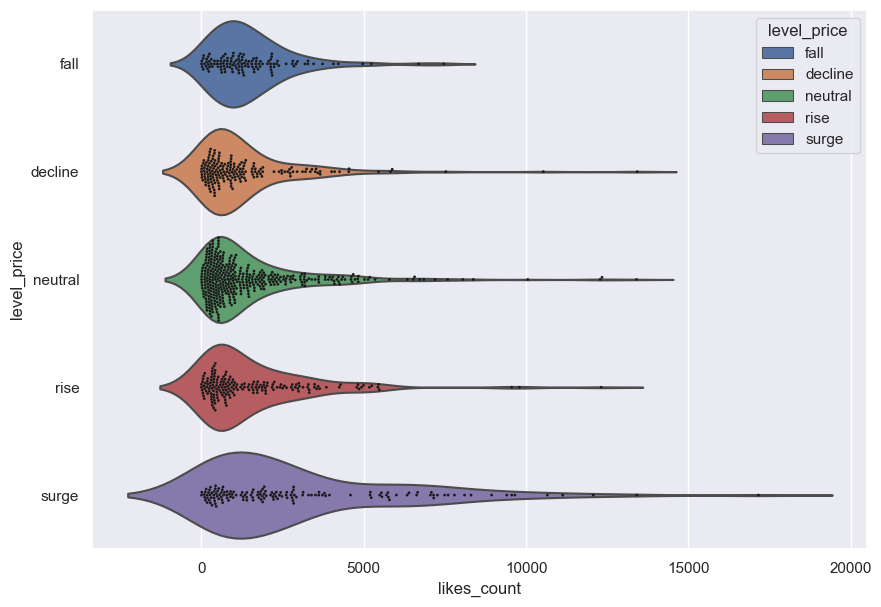

In [94]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="likes_count", y="level_price", hue="level_price", 
               order=list_level_price, hue_order=list_level_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="likes_count", y="level_price", color="k", 
              order=list_level_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_price', ylabel='likes_count'>

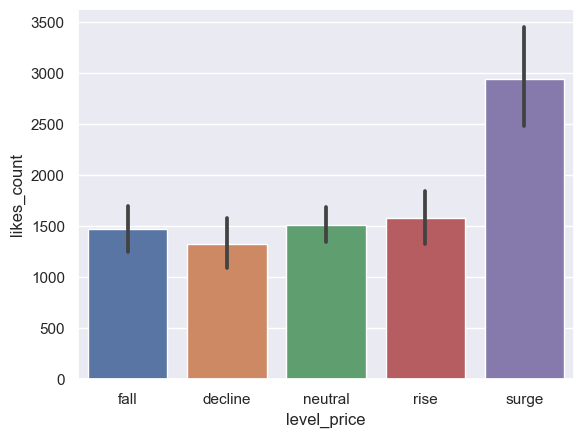

In [95]:
sns.barplot(data=df_nb, x="level_price", y="likes_count",
order=list_level_price)

## Establish the correlation between the price of $OCEAN and the number of retweets generated by tweets containing "$OCEAN". 
What conclusions can be made from this correlation?

Sum re-Tweets for all tweets in a day

In [96]:
df_nb_ret = df_tweets[df_tweets["cash"] == True][["retweets_count", "date_utc"]].groupby("date_utc").sum()
#df_nb_ret.rename(columns={"id":"nb_retweets"}, inplace=True)
df_nb_ret

,retweets_count
date_utc,
2019-12-30,0
2019-12-31,108
2020-01-01,70
2020-01-02,43
2020-01-03,51
...,...
2022-10-17,144
2022-10-18,503
2022-10-19,245


### merge data

In [97]:
df_nb = df_nb_ret.merge(df_nb, how='inner', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,retweets_count,likes_count,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,0,2,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,108,634,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,70,424,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,43,246,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,51,301,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,144,644,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,503,5204,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,245,1618,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,103,847,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


### nb retweets (insights)

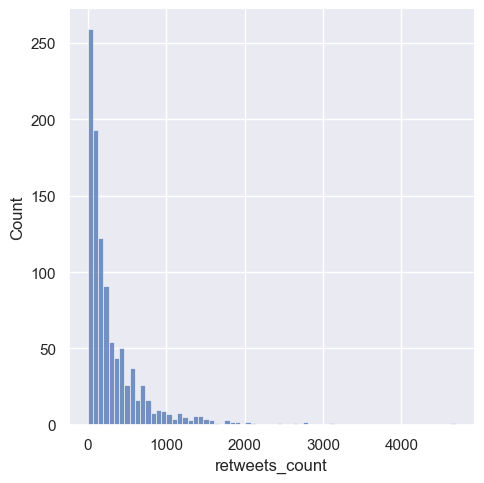

In [98]:
sns.displot(df_nb, x="retweets_count")

<AxesSubplot: xlabel='retweets_count'>

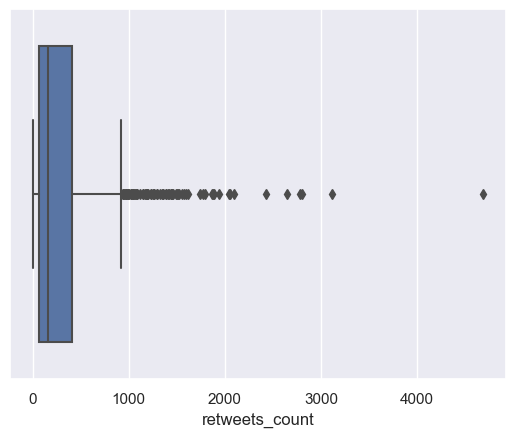

In [99]:
sns.boxplot(x=df_nb["retweets_count"])

### Correlation matrix

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_48356/1150079040.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_nb.corr()


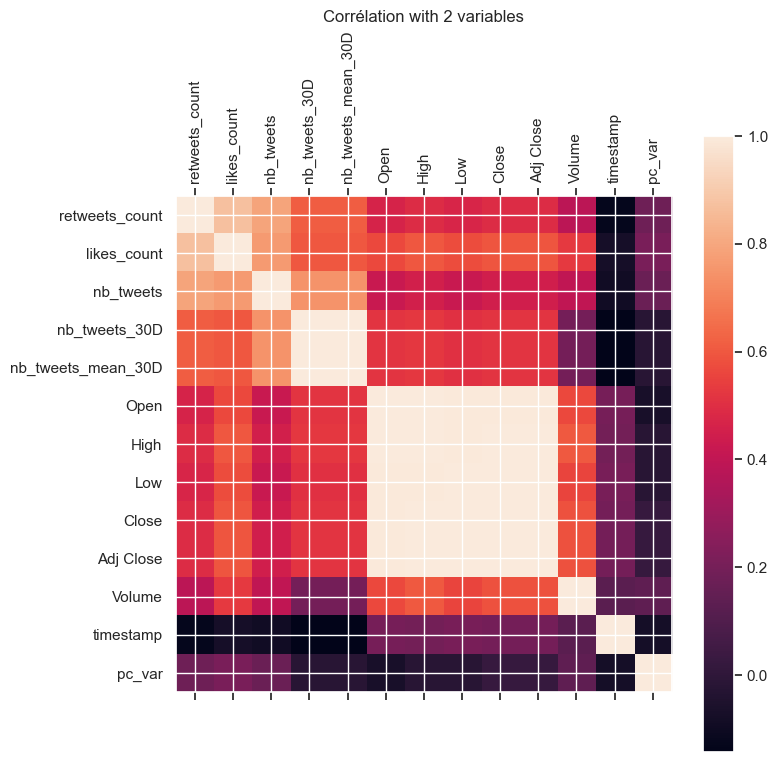

In [100]:
# Calculer la matrice de corrélation
corr_matrix = df_nb.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()

In [101]:
corr_matrix

,retweets_count,likes_count,nb_tweets,nb_tweets_30D,nb_tweets_mean_30D,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
retweets_count,1.000000,0.871170,0.790767,0.615639,0.615639,0.465949,0.494742,0.473187,0.491611,0.491611,0.383980,-0.127137,0.180578
likes_count,0.871170,1.000000,0.765651,0.598796,0.598796,0.565089,0.599180,0.573586,0.598143,0.598143,0.528512,-0.074733,0.211415
nb_tweets,0.790767,0.765651,1.000000,0.745825,0.745825,0.422540,0.454216,0.421602,0.446507,0.446507,0.400476,-0.089938,0.170824
nb_tweets_30D,0.615639,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
nb_tweets_mean_30D,0.615639,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
Open,0.465949,0.565089,0.422540,0.516590,0.516590,1.000000,0.996081,0.995028,0.992612,0.992612,0.563991,0.202958,-0.070888
High,0.494742,0.599180,0.454216,0.522484,0.522484,0.996081,1.000000,0.994099,0.996593,0.996593,0.604973,0.194758,-0.018357
Low,0.473187,0.573586,0.421602,0.507271,0.507271,0.995028,0.994099,1.000000,0.996255,0.996255,0.556484,0.209858,-0.020019
Close,0.491611,0.598143,0.446507,0.517034,0.517034,0.992612,0.996593,0.996255,1.000000,1.000000,0.586463,0.199715,0.022714
Adj Close,0.491611,0.598143,0.446507,0.517034,0.517034,0.992612,0.996593,0.996255,1.000000,1.000000,0.586463,0.199715,0.022714


In [102]:
print("Corr coef nb retweets vs Close: ",  corr_matrix.at["retweets_count", "Close"])
print("Corr coef nb retweets vs pc_var: ",  corr_matrix.at["retweets_count", "pc_var"])

Corr coef nb retweets vs Close:  0.49161125556309676
Corr coef nb retweets vs pc_var:  0.18057793203919179


Correlation coef still not important :
- but more than with nb tweets but less than nb likes 

### By price levels

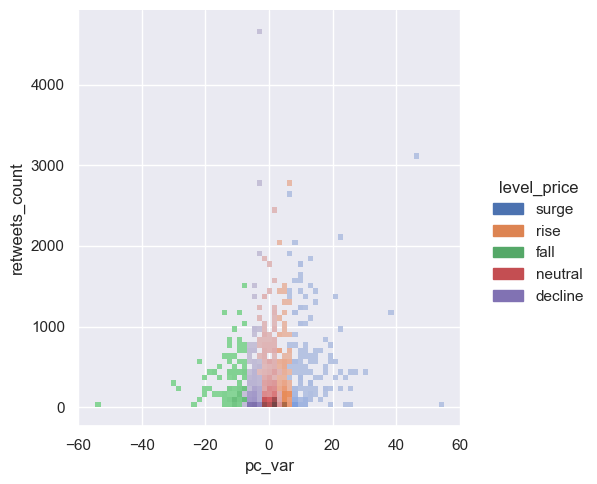

In [103]:
sns.displot(df_nb, x="pc_var", y="retweets_count", hue="level_price")

<AxesSubplot: xlabel='retweets_count', ylabel='level_price'>

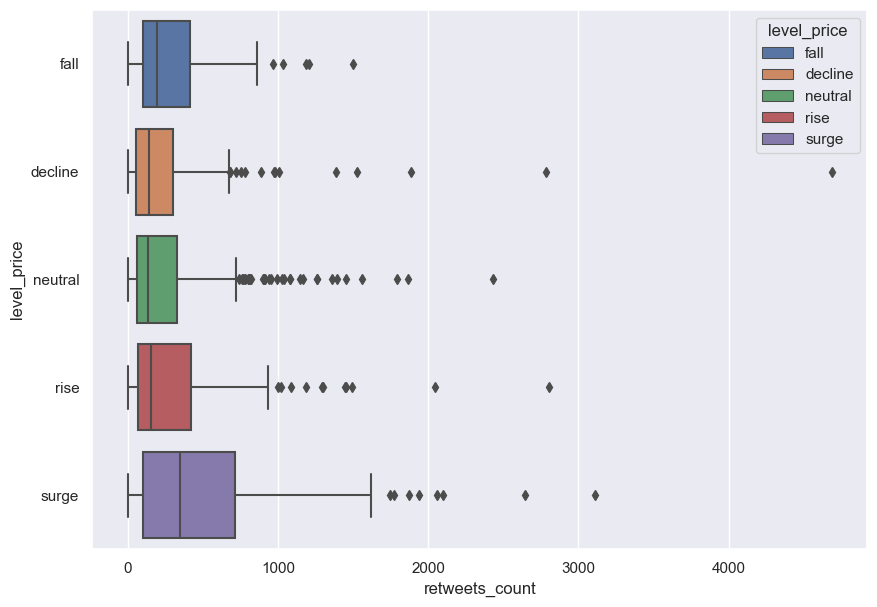

In [104]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="retweets_count", y="level_price", 
    hue="level_price", dodge=False, 
    order=list_level_price, hue_order=list_level_price)

/Users/gregory/miniforge3/envs/ocean_tf_nlp/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='retweets_count', ylabel='level_price'>

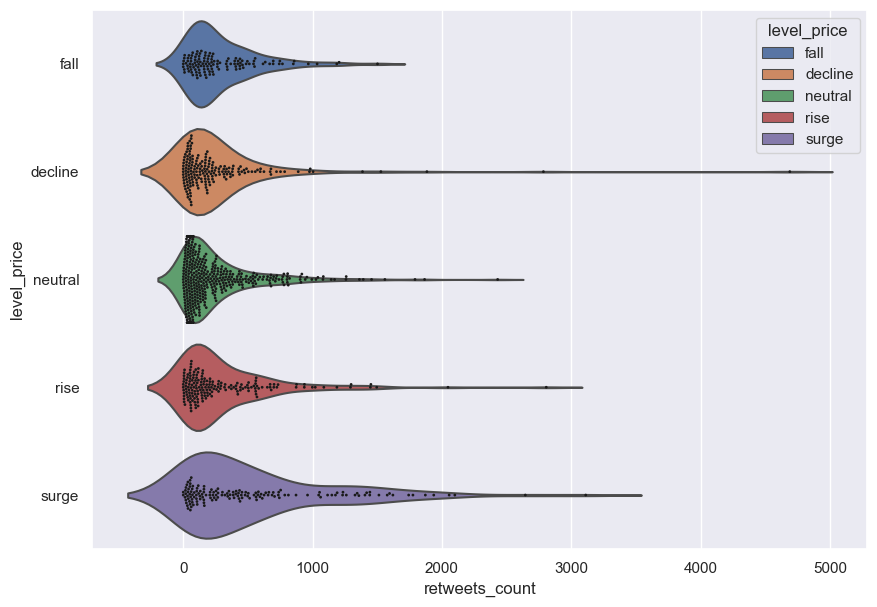

In [105]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="retweets_count", y="level_price", hue="level_price", 
               order=list_level_price, hue_order=list_level_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="pc_var", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="retweets_count", y="level_price", color="k", 
              order=list_level_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_price', ylabel='retweets_count'>

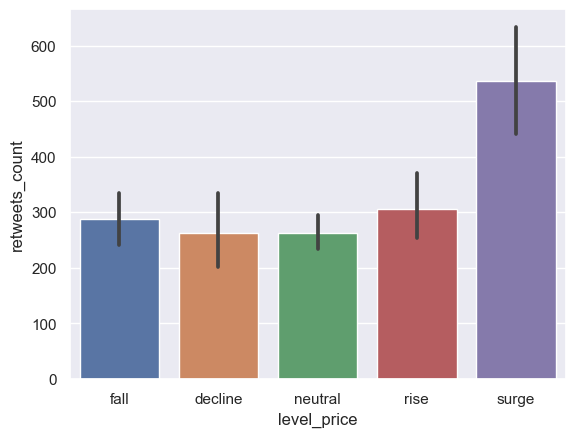

In [106]:
sns.barplot(data=df_nb, x="level_price", y="retweets_count",
order=list_level_price)

## Assess the correlation between the price of $OCEAN and the number of individuals tweeting with the cashtag "$OCEAN". 
What conclusions can be drawn from this correlation?

Sum individuals tweeting each day

In [107]:
df_nb_indiv = df_tweets[df_tweets["cash"] == True][
    ["user_id", "date_utc"]
    ].groupby("date_utc").nunique()
df_nb_indiv.rename(columns={"user_id":"nb_indiv"}, inplace=True)
df_nb_indiv

,nb_indiv
date_utc,
2019-12-30,2
2019-12-31,29
2020-01-01,22
2020-01-02,33
2020-01-03,26
...,...
2022-10-17,92
2022-10-18,293
2022-10-19,168


### merge data

In [108]:
df_nb = df_nb_indiv.merge(df_nb, how='inner', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,nb_indiv,retweets_count,likes_count,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,2,0,2,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,29,108,634,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,22,70,424,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,33,43,246,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,26,51,301,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,92,144,644,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,293,503,5204,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,168,245,1618,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,127,103,847,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


### nb individuals (insights)

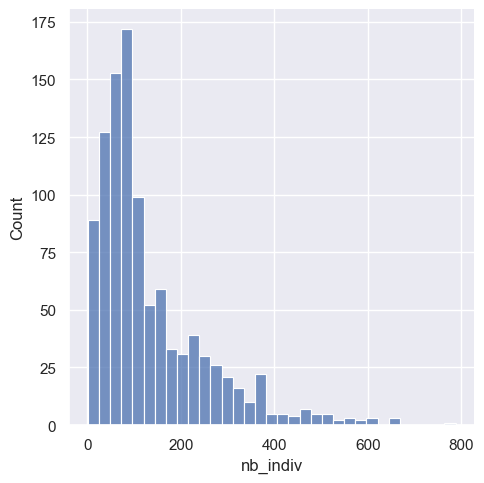

In [109]:
sns.displot(df_nb, x="nb_indiv")

<AxesSubplot: xlabel='nb_indiv'>

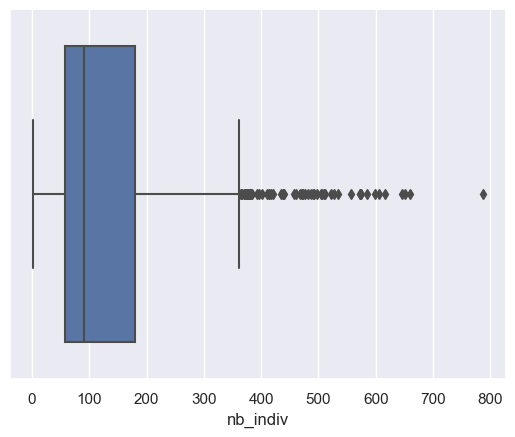

In [110]:
sns.boxplot(x=df_nb["nb_indiv"])

### Correlation matrix

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_48356/1150079040.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_nb.corr()


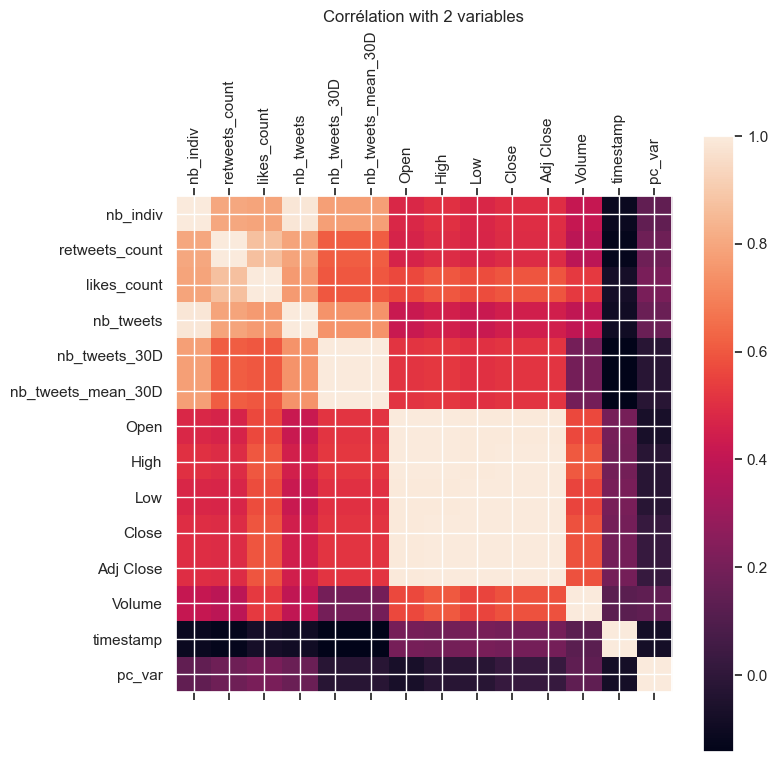

In [111]:
# Calculer la matrice de corrélation
corr_matrix = df_nb.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()

In [112]:
corr_matrix

,nb_indiv,retweets_count,likes_count,nb_tweets,nb_tweets_30D,nb_tweets_mean_30D,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
nb_indiv,1.000000,0.802203,0.792647,0.984776,0.777383,0.777383,0.478313,0.507835,0.476117,0.499816,0.499816,0.414562,-0.110802,0.145142
retweets_count,0.802203,1.000000,0.871170,0.790767,0.615639,0.615639,0.465949,0.494742,0.473187,0.491611,0.491611,0.383980,-0.127137,0.180578
likes_count,0.792647,0.871170,1.000000,0.765651,0.598796,0.598796,0.565089,0.599180,0.573586,0.598143,0.598143,0.528512,-0.074733,0.211415
nb_tweets,0.984776,0.790767,0.765651,1.000000,0.745825,0.745825,0.422540,0.454216,0.421602,0.446507,0.446507,0.400476,-0.089938,0.170824
nb_tweets_30D,0.777383,0.615639,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
nb_tweets_mean_30D,0.777383,0.615639,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
Open,0.478313,0.465949,0.565089,0.422540,0.516590,0.516590,1.000000,0.996081,0.995028,0.992612,0.992612,0.563991,0.202958,-0.070888
High,0.507835,0.494742,0.599180,0.454216,0.522484,0.522484,0.996081,1.000000,0.994099,0.996593,0.996593,0.604973,0.194758,-0.018357
Low,0.476117,0.473187,0.573586,0.421602,0.507271,0.507271,0.995028,0.994099,1.000000,0.996255,0.996255,0.556484,0.209858,-0.020019
Close,0.499816,0.491611,0.598143,0.446507,0.517034,0.517034,0.992612,0.996593,0.996255,1.000000,1.000000,0.586463,0.199715,0.022714


In [113]:
print("Corr coef nb individuals vs Close: ",  corr_matrix.at["nb_indiv", "Close"])
print("Corr coef nb individuals vs pc_var: ",  corr_matrix.at["nb_indiv", "pc_var"])

Corr coef nb individuals vs Close:  0.4998156747689794
Corr coef nb individuals vs pc_var:  0.14514209724207397


Correlation coef still not important :
- same results than for retweets 

### By price levels

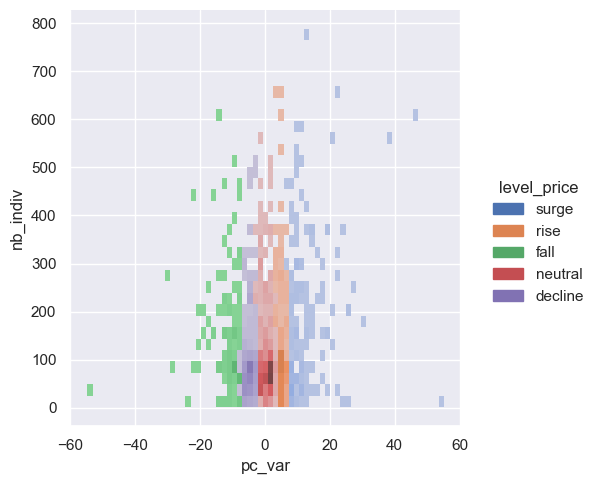

In [114]:
sns.displot(df_nb, x="pc_var", y="nb_indiv", hue="level_price")

<AxesSubplot: xlabel='nb_indiv', ylabel='level_price'>

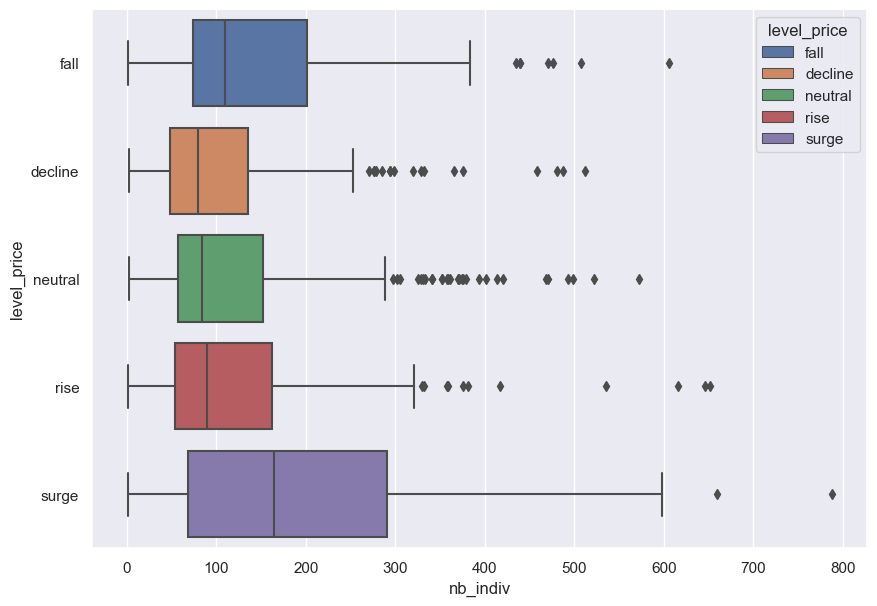

In [115]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="nb_indiv", y="level_price", 
    hue="level_price", dodge=False, 
    order=list_level_price, hue_order=list_level_price)

<AxesSubplot: xlabel='nb_indiv', ylabel='level_price'>

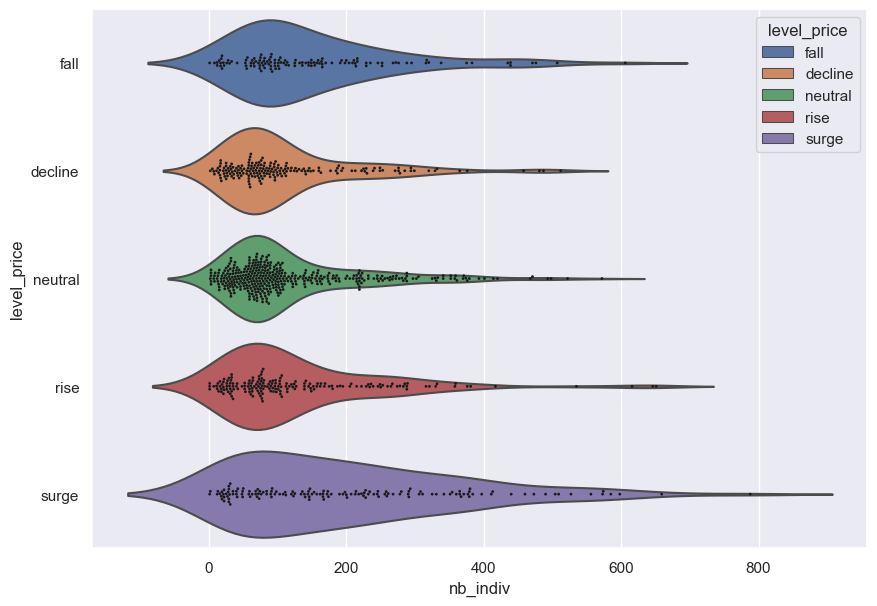

In [116]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="nb_indiv", y="level_price", hue="level_price", 
               order=list_level_price, hue_order=list_level_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="nb_indiv", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="nb_indiv", y="level_price", color="k", 
              order=list_level_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_price', ylabel='nb_indiv'>

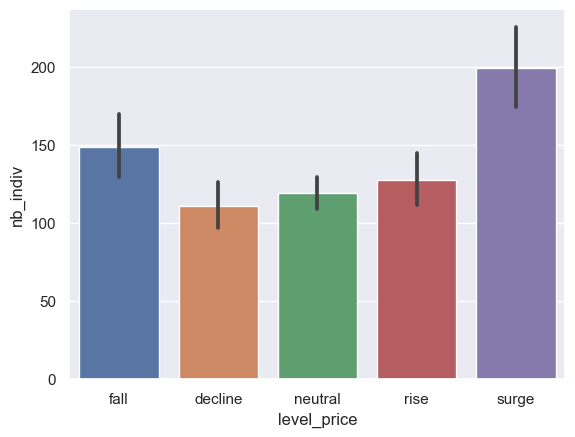

In [117]:
sns.barplot(data=df_nb, x="level_price", y="nb_indiv",
order=list_level_price)

## Analyze the impact of influential tweets on the price of the OCEAN token. 
What conclusions can be drawn from this analysis?

Defition of influential tweet  : > 100 likes

In [118]:
df_tweets[["likes_count","retweets_count"]].describe()

,likes_count,retweets_count
count,229857.000000,229857.000000
mean,7.526432,1.392392
std,45.084299,12.767167
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,0.000000
75%,5.000000,1.000000
max,6363.000000,2556.000000


### nb likes per tweet : insights

In [119]:
df_influ = df_tweets[df_tweets["likes_count"]>=100]
df_influ

,id,reply_to,video,retweet,link,cashtags,hashtags,retweets_count,replies_count,photos,...,time,date,created_at,name,thumbnail,quote_url,time_utc,date_utc,timestamp,cash
317,1583105777803628547,[],1,False,https://twitter.com/eliz883/status/15831057778...,['ocean'],[],23,32,['https://pbs.twimg.com/media/FfhRnqmXgAEMYV6....,...,17:40:04,2022-10-20,2022-10-20 17:40:04 GTB (heure d’été),EliZ¥,https://pbs.twimg.com/media/FfhRnqmXgAEMYV6.jpg,NaN,2022-10-20 14:40:04+00:00,2022-10-20,1.666224e+09,True
544,1582779272673910785,[],0,False,https://twitter.com/THECHAINMEDIA/status/15827...,"['kda', 'icx', 'mina', 'zil', 'rsr', 'ewt', 'm...",[],55,123,[],...,20:02:39,2022-10-19,2022-10-19 20:02:39 GTB (heure d’été),TheBlockchainMedia,NaN,NaN,2022-10-19 17:02:39+00:00,2022-10-19,1.666138e+09,True
644,1582643900237328385,[],1,False,https://twitter.com/eliz883/status/15826439002...,['ocean'],[],15,20,['https://pbs.twimg.com/media/FfauPPJWYAAC-Qo....,...,11:04:44,2022-10-19,2022-10-19 11:04:44 GTB (heure d’été),EliZ¥,https://pbs.twimg.com/media/FfauPPJWYAAC-Qo.jpg,NaN,2022-10-19 08:04:44+00:00,2022-10-19,1.666138e+09,True
849,1582429408635547648,[],1,False,https://twitter.com/eliz883/status/15824294086...,['ocean'],[],12,13,['https://pbs.twimg.com/media/FfXrJObWYAEZ7_M....,...,20:52:25,2022-10-18,2022-10-18 20:52:25 GTB (heure d’été),EliZ¥,https://pbs.twimg.com/media/FfXrJObWYAEZ7_M.jpg,https://twitter.com/eliz883/status/15822568365...,2022-10-18 17:52:25+00:00,2022-10-18,1.666051e+09,True
913,1582407608471650309,[],0,False,https://twitter.com/eliz883/status/15824076084...,"['sushi', 'ocean']",[],8,39,[],...,19:25:48,2022-10-18,2022-10-18 19:25:48 GTB (heure d’été),EliZ¥,NaN,NaN,2022-10-18 16:25:48+00:00,2022-10-18,1.666051e+09,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229387,1217108421385838592,[],0,False,https://twitter.com/tehMoonwalkeR/status/12171...,"['alts', 'dag', 'coti', 'ocean', 'mwat', 'rune']",[],18,8,[],...,17:37:15,2020-01-14,2020-01-14 17:37:15 GTB,tehMoonwalkeR,NaN,https://twitter.com/ICO_Analytics/status/12171...,2020-01-14 14:37:15+00:00,2020-01-14,1.578960e+09,True
229564,1214872811690450948,[],0,False,https://twitter.com/beincrypto/status/12148728...,"['qnt', 'ocean', 'xtz', 'dag', 'fct']",[],49,14,[],...,13:33:44,2020-01-08,2020-01-08 13:33:44 GTB,BeInCrypto,NaN,NaN,2020-01-08 10:33:44+00:00,2020-01-08,1.578442e+09,True
229616,1214239610068492294,[],0,False,https://twitter.com/moonshilla/status/12142396...,"['crypto', 'uos', 'edn', 'pla', 'vra', 'xdb', ...","['dyor', 'altsareback']",29,61,[],...,19:37:37,2020-01-06,2020-01-06 19:37:37 GTB,.. paT◎🌙,NaN,NaN,2020-01-06 16:37:37+00:00,2020-01-06,1.578269e+09,True
229805,1212359940213334017,[],1,False,https://twitter.com/the_ocean_navy/status/1212...,['ocean'],[],40,10,['https://pbs.twimg.com/media/ENMq7paU8AAmJsZ....,...,15:08:28,2020-01-01,2020-01-01 15:08:28 GTB,Ocean Protocol Community,https://pbs.twimg.com/media/ENMq7paU8AAmJsZ.jpg,NaN,2020-01-01 12:08:28+00:00,2020-01-01,1.577837e+09,True


<AxesSubplot: xlabel='likes_count', ylabel='Count'>

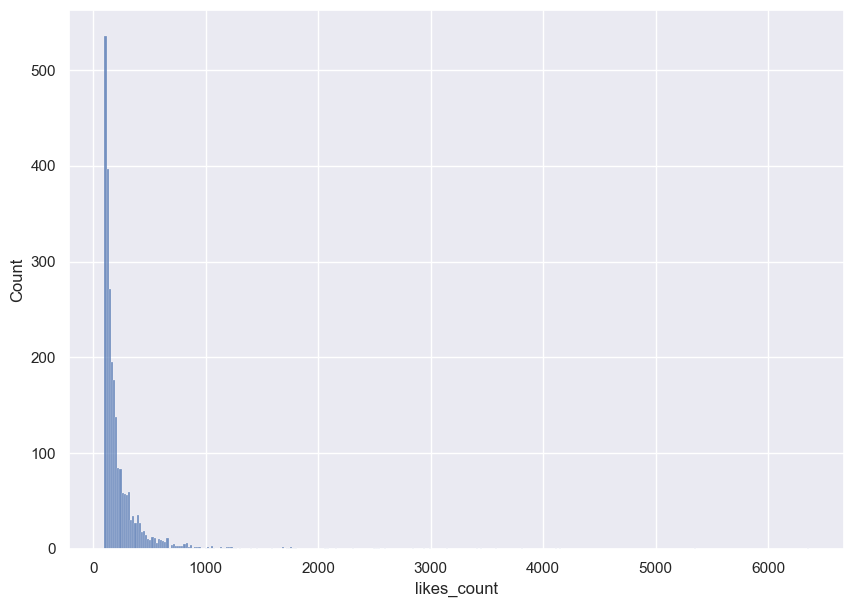

In [120]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(x=df_influ["likes_count"])

/Users/gregory/miniforge3/envs/ocean_tf_nlp/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 39.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot: xlabel='likes_count'>

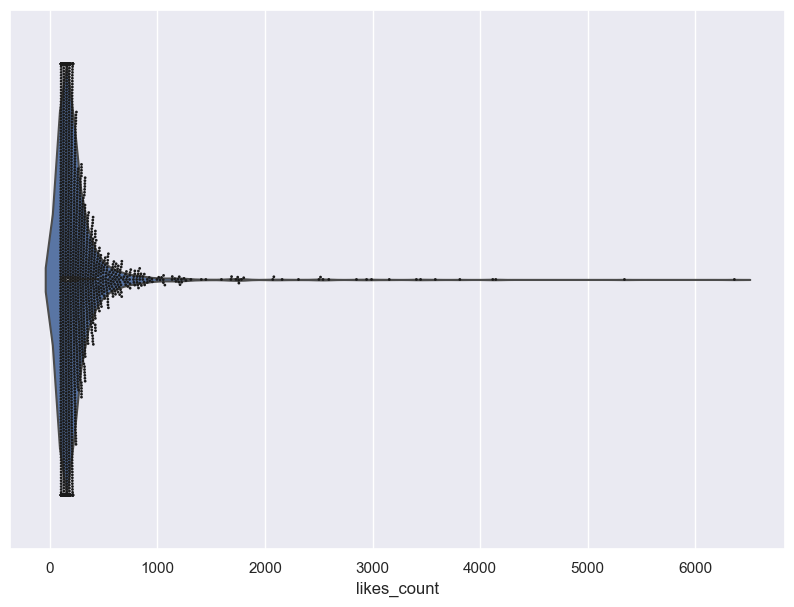

In [121]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(x=df_influ["likes_count"])
sns.swarmplot(data=df_influ, x="likes_count", color="k", 
              size=2, ax=ax)

### Sum influential tweets each day

In [122]:
df_nb_influ = df_influ[df_influ["cash"] == True][
    ["id", "date_utc"]
    ].groupby("date_utc").count()
df_nb_influ.rename(columns={"id":"nb_influ"}, inplace=True)
df_nb_influ

,nb_influ
date_utc,
2019-12-31,1
2020-01-01,1
2020-01-06,1
2020-01-08,1
2020-01-14,1
...,...
2022-10-16,1
2022-10-17,1
2022-10-18,11


<AxesSubplot: xlabel='nb_influ', ylabel='Count'>

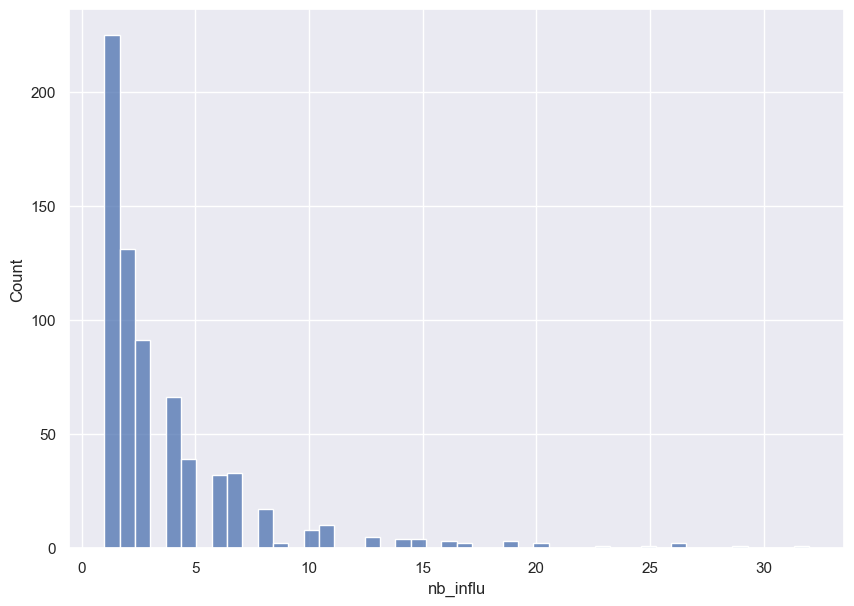

In [123]:
fig = plt.figure(figsize=(10, 7))
sns.histplot(x=df_nb_influ["nb_influ"])

<AxesSubplot: xlabel='nb_influ'>

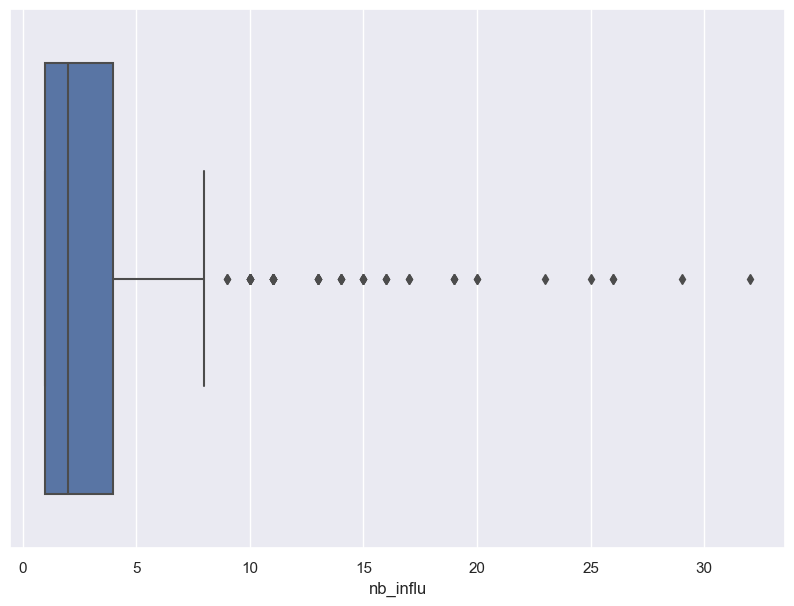

In [124]:

fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df_nb_influ["nb_influ"])

In [125]:
df_nb = df_nb_influ.merge(df_nb, how='right', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,nb_influ,nb_indiv,retweets_count,likes_count,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,NaN,2,0,2,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,1.0,29,108,634,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,1.0,22,70,424,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,NaN,33,43,246,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,NaN,26,51,301,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,1.0,92,144,644,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,11.0,293,503,5204,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,2.0,168,245,1618,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,1.0,127,103,847,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


In [126]:
df_nb.loc[df_nb["nb_influ"].isna(), "nb_influ"] = 0

In [127]:
df_nb

,nb_influ,nb_indiv,retweets_count,likes_count,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,0.0,2,0,2,2,low_nb_tweet,NaN,NaN,2019-12-30,0.030096,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,1.0,29,108,634,35,low_nb_tweet,NaN,NaN,2019-12-31,0.032700,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,1.0,22,70,424,37,low_nb_tweet,NaN,NaN,2020-01-01,0.037197,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,0.0,33,43,246,52,low_nb_tweet,NaN,NaN,2020-01-02,0.039209,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,0.0,26,51,301,38,low_nb_tweet,NaN,NaN,2020-01-03,0.034774,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,1.0,92,144,644,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,0.150487,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,11.0,293,503,5204,686,high_nb_tweet,5760.0,192.000000,2022-10-18,0.152237,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,2.0,168,245,1618,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,0.167924,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,1.0,127,103,847,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,0.164792,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


### Correlation matrix

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_48356/1150079040.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_nb.corr()


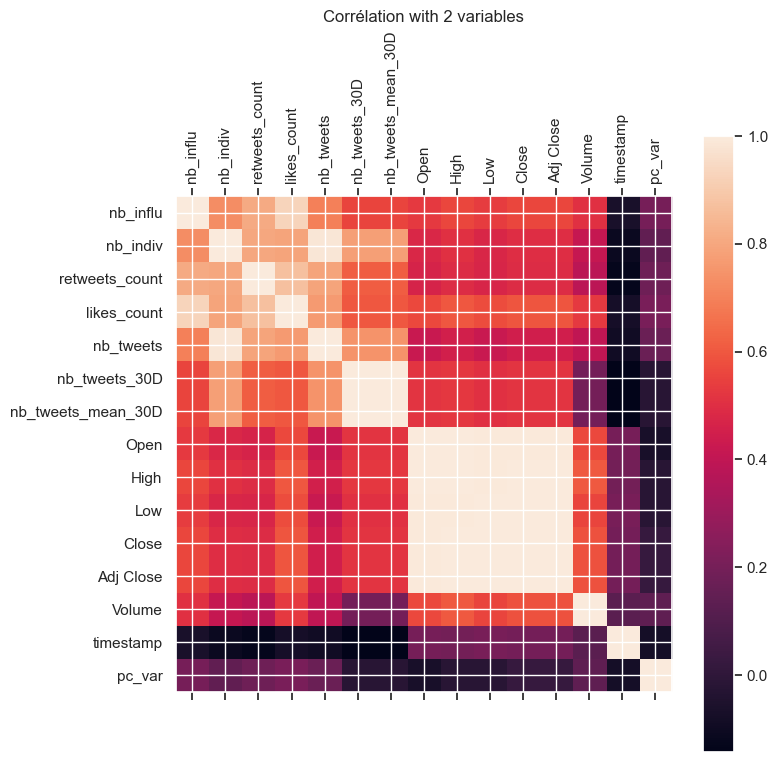

In [128]:
# Calculer la matrice de corrélation
corr_matrix = df_nb.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()

In [129]:
corr_matrix

,nb_influ,nb_indiv,retweets_count,likes_count,nb_tweets,nb_tweets_30D,nb_tweets_mean_30D,Open,High,Low,Close,Adj Close,Volume,timestamp,pc_var
nb_influ,1.000000,0.730437,0.810013,0.931051,0.699428,0.556265,0.556265,0.527638,0.559453,0.537332,0.560370,0.560370,0.506719,-0.065543,0.201397
nb_indiv,0.730437,1.000000,0.802203,0.792647,0.984776,0.777383,0.777383,0.478313,0.507835,0.476117,0.499816,0.499816,0.414562,-0.110802,0.145142
retweets_count,0.810013,0.802203,1.000000,0.871170,0.790767,0.615639,0.615639,0.465949,0.494742,0.473187,0.491611,0.491611,0.383980,-0.127137,0.180578
likes_count,0.931051,0.792647,0.871170,1.000000,0.765651,0.598796,0.598796,0.565089,0.599180,0.573586,0.598143,0.598143,0.528512,-0.074733,0.211415
nb_tweets,0.699428,0.984776,0.790767,0.765651,1.000000,0.745825,0.745825,0.422540,0.454216,0.421602,0.446507,0.446507,0.400476,-0.089938,0.170824
nb_tweets_30D,0.556265,0.777383,0.615639,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
nb_tweets_mean_30D,0.556265,0.777383,0.615639,0.598796,0.745825,1.000000,1.000000,0.516590,0.522484,0.507271,0.517034,0.517034,0.200727,-0.142795,-0.021202
Open,0.527638,0.478313,0.465949,0.565089,0.422540,0.516590,0.516590,1.000000,0.996081,0.995028,0.992612,0.992612,0.563991,0.202958,-0.070888
High,0.559453,0.507835,0.494742,0.599180,0.454216,0.522484,0.522484,0.996081,1.000000,0.994099,0.996593,0.996593,0.604973,0.194758,-0.018357
Low,0.537332,0.476117,0.473187,0.573586,0.421602,0.507271,0.507271,0.995028,0.994099,1.000000,0.996255,0.996255,0.556484,0.209858,-0.020019


In [130]:
corr_matrix[["Close", "pc_var","Low","High"]]

,Close,pc_var,Low,High
nb_influ,0.560370,0.201397,0.537332,0.559453
nb_indiv,0.499816,0.145142,0.476117,0.507835
retweets_count,0.491611,0.180578,0.473187,0.494742
likes_count,0.598143,0.211415,0.573586,0.599180
nb_tweets,0.446507,0.170824,0.421602,0.454216
nb_tweets_30D,0.517034,-0.021202,0.507271,0.522484
nb_tweets_mean_30D,0.517034,-0.021202,0.507271,0.522484
Open,0.992612,-0.070888,0.995028,0.996081
High,0.996593,-0.018357,0.994099,1.000000
Low,0.996255,-0.020019,1.000000,0.994099


Correlation is still not important:  
- less than nb likes
- but more than nb tweets or nb retweets

### By price levels

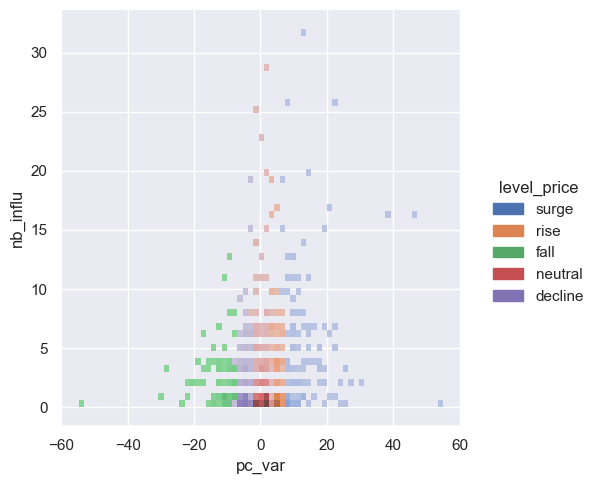

In [131]:
sns.displot(df_nb, x="pc_var", y="nb_influ", hue="level_price")

<AxesSubplot: xlabel='nb_influ', ylabel='level_price'>

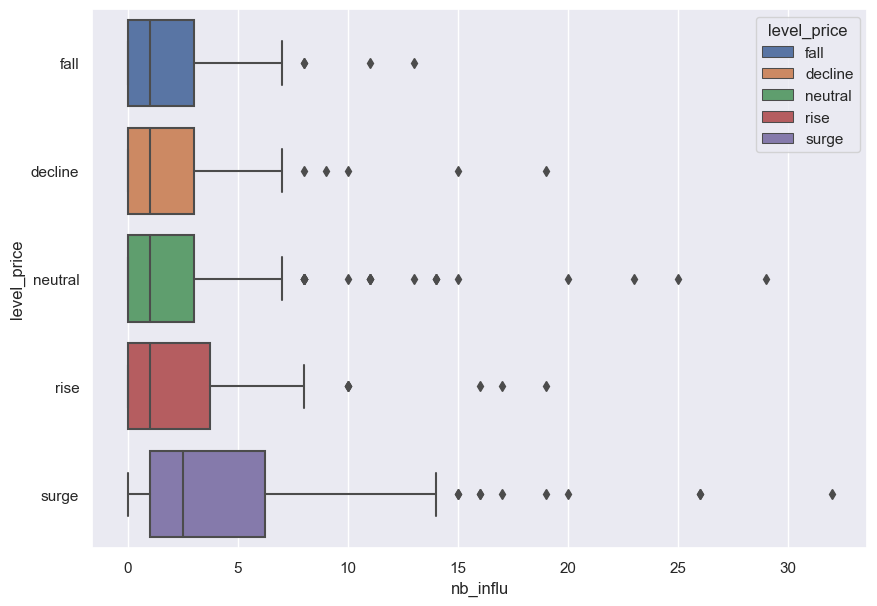

In [132]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df_nb, x="nb_influ", y="level_price", 
    hue="level_price", dodge=False, 
    order=list_level_price, hue_order=list_level_price)

/Users/gregory/miniforge3/envs/ocean_tf_nlp/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 8.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gregory/miniforge3/envs/ocean_tf_nlp/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 29.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gregory/miniforge3/envs/ocean_tf_nlp/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 50.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/gregory/miniforge3/envs/ocean_tf_nlp/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg

<AxesSubplot: xlabel='nb_influ', ylabel='level_price'>

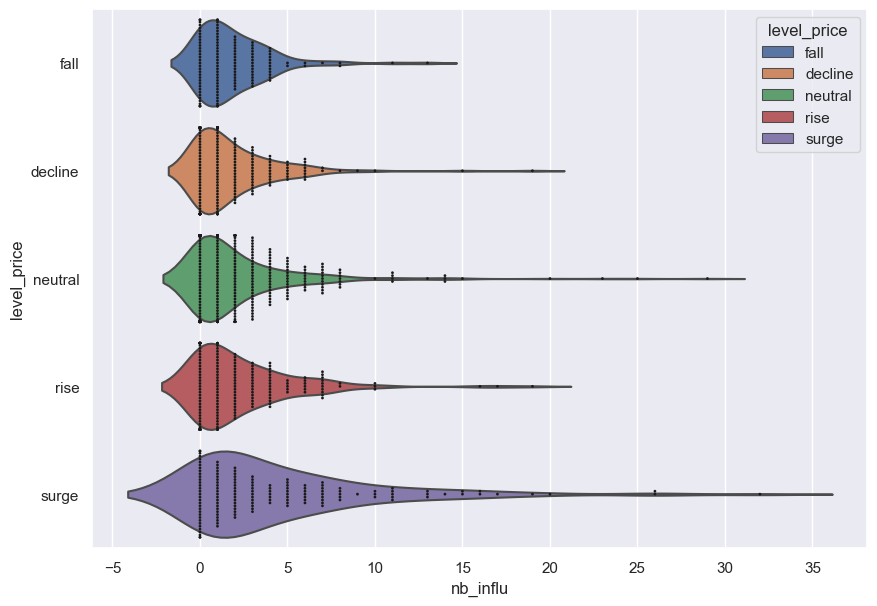

In [133]:
fig = plt.figure(figsize=(10, 7))
ax = fig.gca()
sns.violinplot(data=df_nb, x="nb_influ", y="level_price", hue="level_price", 
               order=list_level_price, hue_order=list_level_price, 
               inner=None, dodge=False)
#sns.catplot(data=df_nb, x="nb_indiv", y="tweet_level", kind="violin", inner=None)
sns.swarmplot(data=df_nb, x="nb_influ", y="level_price", color="k", 
              order=list_level_price,
              size=2, ax=ax)

<AxesSubplot: xlabel='level_price', ylabel='nb_influ'>

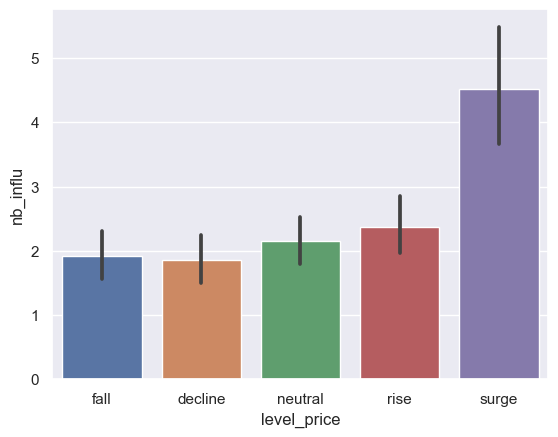

In [134]:
sns.barplot(data=df_nb, x="level_price", y="nb_influ",
order=list_level_price)

In [135]:
df_tweets

,id,reply_to,video,retweet,link,cashtags,hashtags,retweets_count,replies_count,photos,...,time,date,created_at,name,thumbnail,quote_url,time_utc,date_utc,timestamp,cash
0,1583608299085500416,"[{'screen_name': 'JakeGagain', 'name': 'Jake G...",0,False,https://twitter.com/Mxyzptlk07/status/15836082...,['ocean'],"['data', 'web3']",0,0,[],...,02:56:55,2022-10-22,2022-10-22 02:56:55 GTB (heure d’été),Mxyzptlk,NaN,NaN,2022-10-21 23:56:55+00:00,2022-10-21,1.666310e+09,True
1,1583607565543669761,[],0,False,https://twitter.com/Mxyzptlk07/status/15836075...,['ocean'],"['datascientists', 'buidl', 'anewdataeconomy']",0,0,[],...,02:54:00,2022-10-22,2022-10-22 02:54:00 GTB (heure d’été),Mxyzptlk,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:54:00+00:00,2022-10-21,1.666310e+09,True
2,1583603064044367872,[],0,False,https://twitter.com/Moonhodler2/status/1583603...,['ocean'],['data'],0,0,[],...,02:36:07,2022-10-22,2022-10-22 02:36:07 GTB (heure d’été),MOONHODLER,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:36:07+00:00,2022-10-21,1.666310e+09,True
3,1583598008511664128,"[{'screen_name': 'CryptoGemsCom', 'name': 'The...",0,False,https://twitter.com/rjgaurav338/status/1583598...,"['ocean', 'bnb', 'eth']",[],0,0,[],...,02:16:01,2022-10-22,2022-10-22 02:16:01 GTB (heure d’été),rikdbxs,NaN,NaN,2022-10-21 23:16:01+00:00,2022-10-21,1.666310e+09,True
4,1583595987851173888,"[{'screen_name': 'cryptoworld202', 'name': 'Cr...",1,False,https://twitter.com/StringerBcoiner/status/158...,"['ocean', 'ltc', 'ngm', 'dafi', 'esek', 'enok'...","['ngm', 'dafi', 'ngm']",0,1,['https://pbs.twimg.com/media/FfoQJTUWQAMjfYy....,...,02:07:59,2022-10-22,2022-10-22 02:07:59 GTB (heure d’été),StringerBitcoiner,https://pbs.twimg.com/media/FfoQJTUWQAMjfYy.jpg,NaN,2022-10-21 23:07:59+00:00,2022-10-21,1.666310e+09,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229852,1211845595977019392,[],0,False,https://twitter.com/Mojo_Crypto_BTC/status/121...,"['xrp', 'perl', 'nrg', 'ocean']",[],0,0,[],...,05:04:39,2019-12-31,2019-12-31 05:04:39 GTB,🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL,NaN,NaN,2019-12-31 02:04:39+00:00,2019-12-31,1.577750e+09,True
229853,1211830366513901568,"[{'screen_name': 'DaveCryptos', 'name': 'Dave ...",0,False,https://twitter.com/harmoniccapital/status/121...,['ocean'],[],0,0,[],...,04:04:08,2019-12-31,2019-12-31 04:04:08 GTB,Harmonic Capital,NaN,NaN,2019-12-31 01:04:08+00:00,2019-12-31,1.577750e+09,True
229854,1211818209738817536,[],0,False,https://twitter.com/bakeobits/status/121181820...,"['ins', 'ocean', 'ins']",[],0,2,[],...,03:15:50,2019-12-31,2019-12-31 03:15:50 GTB,ShillSilverstein.kek 📈👑📉,NaN,NaN,2019-12-31 00:15:50+00:00,2019-12-31,1.577750e+09,True
229855,1211808120659300352,[],1,False,https://twitter.com/bakeobits/status/121180812...,['ocean'],[],0,2,['https://pbs.twimg.com/media/ENE1D4GUYAAWcVh....,...,02:35:44,2019-12-31,2019-12-31 02:35:44 GTB,ShillSilverstein.kek 📈👑📉,https://pbs.twimg.com/media/ENE1D4GUYAAWcVh.jpg,NaN,2019-12-30 23:35:44+00:00,2019-12-30,1.577664e+09,True


## Prediction Model:

Develop a machine learning model capable of classifying tweets as bullish, bearish, or neutral. You have the freedom to use any dataset for this task.

### Use TextBlob out of the box
Using this library is done directly without tuning because lack of time.  
I am sure it is not optimized.  
Results seems to lead to classify a lot of fake negative tweets  

In [136]:

def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters
    using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'bullish'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'bearish'

In [137]:
df_tweets["tweet"].values[0]

'@JakeGagain Get an $OCEAN bag, no matter how small. There is a huge demand for data scientists in the workforce, this shows the world is moving towards #data economy.  @Oceanprotocol contributes solves the data sharing challenge through #web3. A big gem.'

In [138]:
clean_tweet(df_tweets["tweet"].values[0])

'Get an OCEAN bag no matter how small There is a huge demand for data scientists in the workforce this shows the world is moving towards data economy contributes solves the data sharing challenge through web3 A big gem'

In [139]:
get_tweet_sentiment(df_tweets["tweet"].values[0])

'bullish'

In [140]:
df_tweets["senti"] = df_tweets["tweet"].apply(get_tweet_sentiment)
df_tweets

,id,reply_to,video,retweet,link,cashtags,hashtags,retweets_count,replies_count,photos,...,date,created_at,name,thumbnail,quote_url,time_utc,date_utc,timestamp,cash,senti
0,1583608299085500416,"[{'screen_name': 'JakeGagain', 'name': 'Jake G...",0,False,https://twitter.com/Mxyzptlk07/status/15836082...,['ocean'],"['data', 'web3']",0,0,[],...,2022-10-22,2022-10-22 02:56:55 GTB (heure d’été),Mxyzptlk,NaN,NaN,2022-10-21 23:56:55+00:00,2022-10-21,1.666310e+09,True,bullish
1,1583607565543669761,[],0,False,https://twitter.com/Mxyzptlk07/status/15836075...,['ocean'],"['datascientists', 'buidl', 'anewdataeconomy']",0,0,[],...,2022-10-22,2022-10-22 02:54:00 GTB (heure d’été),Mxyzptlk,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:54:00+00:00,2022-10-21,1.666310e+09,True,bullish
2,1583603064044367872,[],0,False,https://twitter.com/Moonhodler2/status/1583603...,['ocean'],['data'],0,0,[],...,2022-10-22,2022-10-22 02:36:07 GTB (heure d’été),MOONHODLER,NaN,https://twitter.com/oceanprotocol/status/15834...,2022-10-21 23:36:07+00:00,2022-10-21,1.666310e+09,True,bullish
3,1583598008511664128,"[{'screen_name': 'CryptoGemsCom', 'name': 'The...",0,False,https://twitter.com/rjgaurav338/status/1583598...,"['ocean', 'bnb', 'eth']",[],0,0,[],...,2022-10-22,2022-10-22 02:16:01 GTB (heure d’été),rikdbxs,NaN,NaN,2022-10-21 23:16:01+00:00,2022-10-21,1.666310e+09,True,neutral
4,1583595987851173888,"[{'screen_name': 'cryptoworld202', 'name': 'Cr...",1,False,https://twitter.com/StringerBcoiner/status/158...,"['ocean', 'ltc', 'ngm', 'dafi', 'esek', 'enok'...","['ngm', 'dafi', 'ngm']",0,1,['https://pbs.twimg.com/media/FfoQJTUWQAMjfYy....,...,2022-10-22,2022-10-22 02:07:59 GTB (heure d’été),StringerBitcoiner,https://pbs.twimg.com/media/FfoQJTUWQAMjfYy.jpg,NaN,2022-10-21 23:07:59+00:00,2022-10-21,1.666310e+09,True,bullish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229852,1211845595977019392,[],0,False,https://twitter.com/Mojo_Crypto_BTC/status/121...,"['xrp', 'perl', 'nrg', 'ocean']",[],0,0,[],...,2019-12-31,2019-12-31 05:04:39 GTB,🦍🔥 ✧🔮 ጠዐጋዐ ƈཞ ⓨ ℘ɬዐ🔮✧ 🔥🦍 JNGL,NaN,NaN,2019-12-31 02:04:39+00:00,2019-12-31,1.577750e+09,True,neutral
229853,1211830366513901568,"[{'screen_name': 'DaveCryptos', 'name': 'Dave ...",0,False,https://twitter.com/harmoniccapital/status/121...,['ocean'],[],0,0,[],...,2019-12-31,2019-12-31 04:04:08 GTB,Harmonic Capital,NaN,NaN,2019-12-31 01:04:08+00:00,2019-12-31,1.577750e+09,True,bullish
229854,1211818209738817536,[],0,False,https://twitter.com/bakeobits/status/121181820...,"['ins', 'ocean', 'ins']",[],0,2,[],...,2019-12-31,2019-12-31 03:15:50 GTB,ShillSilverstein.kek 📈👑📉,NaN,NaN,2019-12-31 00:15:50+00:00,2019-12-31,1.577750e+09,True,bullish
229855,1211808120659300352,[],1,False,https://twitter.com/bakeobits/status/121180812...,['ocean'],[],0,2,['https://pbs.twimg.com/media/ENE1D4GUYAAWcVh....,...,2019-12-31,2019-12-31 02:35:44 GTB,ShillSilverstein.kek 📈👑📉,https://pbs.twimg.com/media/ENE1D4GUYAAWcVh.jpg,NaN,2019-12-30 23:35:44+00:00,2019-12-30,1.577664e+09,True,neutral


In [141]:
df_tweets["senti"].value_counts()

neutral    106108
bullish    102168
bearish     21581
Name: senti, dtype: int64

In [142]:
df_tweets[df_tweets["senti"] == "bearish"]["tweet"].values[0]

'Here is my analysis of $OCEAN: Price is now testing the daily support zone and a bounce is expected from here.The big wick on the upside shows profit booking/position closing by big players.A daily candle closes below $0.145 will push the market downwards.  #Laura_90fx  https://t.co/nWxRhHsW9B'

In [143]:
df_tweets[df_tweets["senti"] == "bearish"]["tweet"].values[1]

'@CryptoTigerCom @AltcoinWorldcom $FTM, $DAFI, $CARD, $NGM &amp; $OCEAN for a start!  As a blockchain-based payment platform @emoney_com  is committed to bringing financial inclusion via interest bearing, fully backed and compliant stablecoins.  Definitely going to be massive in the next few years!  #DeFi #Altcoins  https://t.co/OunmbFh0pG'

In [144]:
df_tweets[df_tweets["senti"] == "bullish"]["tweet"].values[2]

'"The Energy Efficiency Data challenge is designed to harness the power of energy data, build algorithms that facilitate innovation and spearhead the shift towards smarter, greener, more efficient buildings for global change."  $OCEAN 🤝 Real World  @Oceanprotocol  #data'

In [145]:
df_tweets[df_tweets["senti"] == "neutral"]["tweet"].values[2]

"@Cryptogems223 $DOT $MATIC $OCEAN &amp; $DAFI are on my radar.  My strategy is DCA and generating passive income.  Patience will pay off. Let's wait for the bulls to come back!"

In [146]:
df_tweets[df_tweets["senti"] == "neutral"]["tweet"].values[10]

'$ocean looking bullish , if it holds above 0.155$ it will print 10-20 % in next 16 hours .'

In [147]:
df_tweets[df_tweets["senti"] == "bearish"]["tweet"].values[3]

"$OCEAN   Don't Miss the Next move In a few hours,.   https://t.co/GIJVQyzGDm"

In [148]:
df_tweets[df_tweets["senti"] == "bearish"]["tweet"].values[51:100]

array(['sorry for those who buying in fomo #ocean $ocean  buy 0.1596  TP 1 0.193  TP2 0.32  SL 0.147 1D close  https://t.co/UbNR8VAHtR',
       '$OCEAN possible swing LONG from this level to 0.15865$. Required leverage is 10X. Stop loss at 0.155$. Take profit at 0.177$. @CryptoDefiLord @ZeddYakuza  https://t.co/yGWAFQslqh',
       '$OCEAN if you have little IQ in this world you will go rekt .... always try to evaluate and reason with your head!  https://t.co/pseDslobF1',
       "All these prices are a steal! It's actually quite ridiculous. $BTC $ETH $LINK $DAG $OCEAN $TRIAS $AZERO $HTR",
       '$ocean update   Retraced as expected...  Need to reclaim 0.1645$ for any bullish continuation...   #oceanprotocol #ocean #web3 #sp500 #spx #bitcoin #btc #ethereum #eth #solana #sol #cardano #ada #xrp #ripple #binance #bnb #polkadot #trias #htr #ariva  https://t.co/dXoyy0BkkT',
       '$OCEAN and $PSDN being chads. Making the move towards the ve tokenomics turned things around for @oceanprotocol

More than 80% of Tweets in English

In [149]:
df_tweets["language"].value_counts()/df_tweets.shape[0]*100

en     81.503718
qme     3.175453
in      2.870480
und     2.559852
ro      1.686266
es      1.192045
tr      1.178559
ja      0.700871
pt      0.647359
sv      0.503791
qct     0.492915
nl      0.436358
tl      0.377191
it      0.360659
fr      0.358484
da      0.351523
cy      0.241019
ca      0.223182
ht      0.179677
fi      0.170106
no      0.131821
de      0.106153
ar      0.104848
sl      0.086576
pl      0.070914
ru      0.044810
eu      0.043505
cs      0.041765
et      0.039155
fa      0.019577
hu      0.016532
zh      0.013052
is      0.013052
ko      0.013052
vi      0.011311
lt      0.010441
th      0.010006
el      0.005656
hi      0.003480
lv      0.002610
uk      0.001305
mr      0.000435
bg      0.000435
Name: language, dtype: float64

## Apply this model to tweets containing $OCEAN and observe how investor sentiment towards the token evolves. 
Is there a correlation between investor sentiment and the token's price?

### Sum sentiments for each day

In [150]:
# model 1
def fun_senti(ser_senti_curr):
    val_count = ser_senti_curr.value_counts()
    if len(val_count) < 2:
        return val_count.index[0]
    if val_count[0] > val_count[1]:
        return val_count.index[0]
    else:
        return "neutral"

In [151]:
# model 2 
def fun_senti(ser_senti_curr):
    val_count = ser_senti_curr.value_counts()
    if len(val_count) < 2:
        return val_count.index[0]
    if val_count[0] > val_count[1]:
        return val_count.index[0]
    else:
        # first = second
        if (val_count[0] == "neutral"):
            if len(val_count) > 2:
                if val_count[1] > val_count[2]:
                    return val_count.index[1]
                else:
                    return "neutral"
            else:
                return val_count.index[1]
        elif (val_count[1] == "neutral"):
            if len(val_count) > 2:
                if val_count[0] > val_count[2]:
                    return val_count.index[0]
                else:
                    return "neutral"
            else:
                return val_count.index[0]
        else:
            if val_count[0] > val_count[1]:
                return val_count.index[0]
            else:
                return "neutral"

In [152]:
# model 3
def fun_senti(ser_senti_curr):
    val_count = ser_senti_curr.value_counts()
    if "bearish" in list(val_count.index):
        if val_count["bearish"] / sum(val_count) > 0.15:
            return "bearish"
    if len(val_count) < 2:
        return val_count.index[0]
    if val_count[0]/sum(val_count) - val_count[1]/ sum(val_count) > 0.15:
        return val_count.index[0]
    else:
        return "neutral"

In [153]:
df_senti = df_tweets[df_tweets["cash"] == True][
    ["senti", "date_utc"]
    ].groupby("date_utc",
    group_keys=False).apply(lambda x: fun_senti(x["senti"]))
#df_senti.rename(columns={"id":"nb_influ"}, inplace=True)
df_senti = pd.DataFrame(df_senti, columns=["senti"])
df_senti

,senti
date_utc,
2019-12-30,neutral
2019-12-31,bullish
2020-01-01,bullish
2020-01-02,bullish
2020-01-03,neutral
...,...
2022-10-17,bullish
2022-10-18,neutral
2022-10-19,bullish


In [154]:
df_senti["senti"].value_counts()

neutral    727
bullish    159
bearish    138
Name: senti, dtype: int64

In [155]:
df_nb["level_stat_price"].value_counts()

neutral    815
bearish    106
bullish    103
Name: level_stat_price, dtype: int64

In [156]:
df_nb = df_senti.merge(df_nb, how='inner', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,senti,nb_influ,nb_indiv,retweets_count,likes_count,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,Date,...,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
238,neutral,0.0,2,0,2,2,low_nb_tweet,NaN,NaN,2019-12-30,...,0.033129,0.029338,0.032726,0.032726,11037407,1.577664e+09,8.738703,bullish,surge,0
239,bullish,1.0,29,108,634,35,low_nb_tweet,NaN,NaN,2019-12-31,...,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,bullish,1.0,22,70,424,37,low_nb_tweet,NaN,NaN,2020-01-01,...,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,bullish,0.0,33,43,246,52,low_nb_tweet,NaN,NaN,2020-01-02,...,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,neutral,0.0,26,51,301,38,low_nb_tweet,NaN,NaN,2020-01-03,...,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,bullish,1.0,92,144,644,156,normal_nb_tweet,5208.0,173.600000,2022-10-17,...,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,neutral,11.0,293,503,5204,686,high_nb_tweet,5760.0,192.000000,2022-10-18,...,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,bullish,2.0,168,245,1618,273,normal_nb_tweet,5854.0,195.133333,2022-10-19,...,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,bullish,1.0,127,103,847,226,normal_nb_tweet,5835.0,194.500000,2022-10-20,...,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


In [157]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [158]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

In [159]:
target_names = np.array(["bearish", "neutral", "bullish"])
def fun_num_class(str_class):
    if str_class == "bearish":
        return 0
    elif str_class == "neutral":
        return 1
    else:
        return 2

Confusion matrix, without normalization
[[ 23  74   9]
 [109 564 142]
 [  6  89   8]]


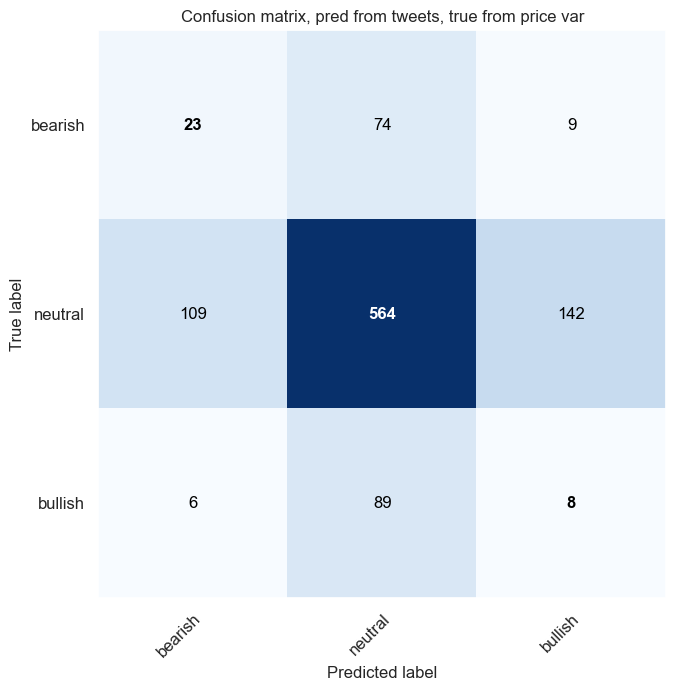

In [160]:
Y_test_num = df_nb["level_stat_price"].apply(fun_num_class).values.astype(np.int64)
Y_test_pred_num = df_nb["senti"].apply(fun_num_class).values.astype(np.int64)
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(Y_test_num, Y_test_pred_num, classes=target_names,
  title="Confusion matrix, pred from tweets, true from price var", size=8,
   fontsize=12)

## Use tweet 3 hours before

In [162]:
df_tweets[["date", "date_utc"]]

,date,date_utc
0,2022-10-22,2022-10-21
1,2022-10-22,2022-10-21
2,2022-10-22,2022-10-21
3,2022-10-22,2022-10-21
4,2022-10-22,2022-10-21
...,...,...
229852,2019-12-31,2019-12-31
229853,2019-12-31,2019-12-31
229854,2019-12-31,2019-12-31
229855,2019-12-31,2019-12-30


In [164]:
df_senti = df_tweets[df_tweets["cash"] == True][
    ["senti", "date"]
    ].groupby("date",
    group_keys=False).apply(lambda x: fun_senti(x["senti"]))
#df_senti.rename(columns={"id":"nb_influ"}, inplace=True)
df_senti = pd.DataFrame(df_senti, columns=["senti_3h"])
df_senti

,senti_3h
date,
2019-12-31,bearish
2020-01-01,bullish
2020-01-02,bullish
2020-01-03,neutral
2020-01-04,neutral
...,...
2022-10-18,neutral
2022-10-19,bullish
2022-10-20,bullish


In [165]:
df_nb = df_senti.merge(df_nb, how='inner', left_index=True, right_on='Date', suffixes=(False, False))
df_nb

,senti_3h,senti,nb_influ,nb_indiv,retweets_count,likes_count,nb_tweets,level_tweets,nb_tweets_30D,nb_tweets_mean_30D,...,High,Low,Close,Adj Close,Volume,timestamp,pc_var,level_stat_price,level_price,tweet_level
239,bearish,bullish,1.0,29,108,634,35,low_nb_tweet,NaN,NaN,...,0.038978,0.032562,0.037197,0.037197,12297226,1.577750e+09,13.752294,bullish,surge,0
240,bullish,bullish,1.0,22,70,424,37,low_nb_tweet,NaN,NaN,...,0.039687,0.034801,0.039226,0.039226,12577450,1.577837e+09,5.454741,neutral,rise,0
241,bullish,bullish,0.0,33,43,246,52,low_nb_tweet,NaN,NaN,...,0.039322,0.034053,0.034784,0.034784,10414026,1.577923e+09,-11.285674,bearish,fall,100
242,neutral,neutral,0.0,26,51,301,38,low_nb_tweet,NaN,NaN,...,0.038628,0.034186,0.036693,0.036693,11271250,1.578010e+09,5.518491,neutral,rise,0
243,neutral,bullish,0.0,15,58,252,24,low_nb_tweet,NaN,NaN,...,0.037932,0.034299,0.035934,0.035934,9659167,1.578096e+09,-2.623164,neutral,neutral,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260,bullish,bullish,1.0,92,144,644,156,normal_nb_tweet,5208.0,173.600000,...,0.152528,0.148830,0.152231,0.152231,4791953,1.665965e+09,1.158904,neutral,neutral,200
1261,neutral,neutral,11.0,293,503,5204,686,high_nb_tweet,5760.0,192.000000,...,0.199573,0.151643,0.167960,0.167960,86145727,1.666051e+09,10.327975,bullish,surge,700
1262,bullish,bullish,2.0,168,245,1618,273,normal_nb_tweet,5854.0,195.133333,...,0.167924,0.160154,0.164779,0.164779,20414280,1.666138e+09,-1.872871,neutral,neutral,300
1263,bullish,bullish,1.0,127,103,847,226,normal_nb_tweet,5835.0,194.500000,...,0.167368,0.162250,0.165510,0.165510,10699438,1.666224e+09,0.435701,neutral,neutral,200


Confusion matrix, without normalization
[[ 23  71  12]
 [114 567 132]
 [ 10  84   8]]


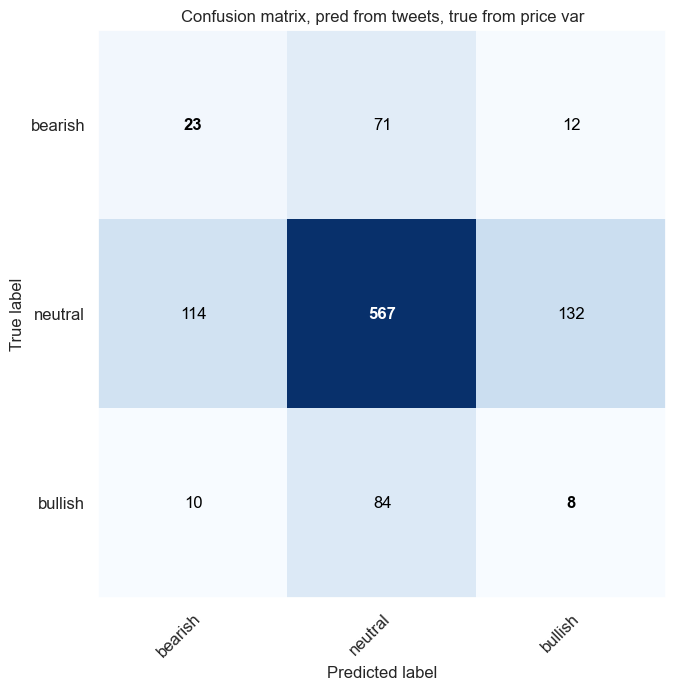

In [166]:
Y_test_num = df_nb["level_stat_price"].apply(fun_num_class).values.astype(np.int64)
Y_test_pred_num = df_nb["senti_3h"].apply(fun_num_class).values.astype(np.int64)
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(Y_test_num, Y_test_pred_num, classes=target_names,
  title="Confusion matrix, pred from tweets, true from price var", size=8,
   fontsize=12)